# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import time

import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
from keras import backend as K
from keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from utils import scoring_utils
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = layers.SeparableConv2D(filters, kernel_size=3, strides=strides, padding='same',
                                          activation='relu')(input_layer)
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    return layers.UpSampling2D(size=(2, 2))(input_layer)

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    ups = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    cat = layers.concatenate([ups, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(cat, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def showShape( mlayer, name = '' ) :
    print( name + ' : ', mlayer.get_shape().as_list() )

def fcn_model(inputs, num_classes):
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    enc1 = encoder_block(inputs, 8, 1)
    enc2 = encoder_block(enc1, 8, 2)
    enc2 = encoder_block(enc2, 16, 1)
    #pol2 = layers.MaxPooling2D()(enc1)
    enc3 = encoder_block(enc2, 16, 2)
    enc3 = encoder_block(enc3, 32, 1)
    #pol3 = layers.MaxPooling2D()(enc2)
    enc4 = encoder_block(enc3, 3, 1)
    #pool2 = layers.MaxPooling2D()(enc2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    #conv = conv2d_batchnorm(inputs, 50, kernel_size=1)
    #conv = layers.Dropout(0.5)(conv)
    #showShape(conv, 'conv')
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x = layers.concatenate([enc3, enc4])    
    x = decoder_block(x, enc2, 3)
    #x = layers.concatenate([x, pol2]) 
    x = decoder_block(x, enc1, 3)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

INFO:plaidml:Opening device "metal_nvidia_geforce_gtx_950.0"


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [11]:
learning_rate = 0.007
batch_size = 64
num_epochs = 250
decay_rate = 0#learning_rate / num_epochs / 4
steps_per_epoch = 40
validation_steps = 20
workers = 4

Epoch 1/250


INFO:plaidml:Analyzing Ops: 535 of 1594 operations complete


 2/40 [>.............................] - ETA: 1:45 - loss: 1.1399

INFO:plaidml:Analyzing Ops: 535 of 1594 operations complete


40/40 [==============================] - 41s 1s/step - loss: 0.8381 - val_loss: 0.5106


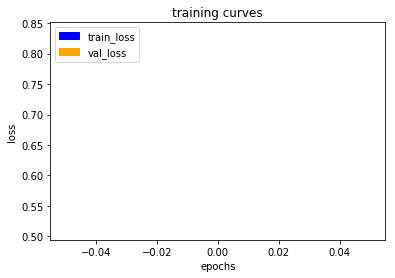


Epoch 00001: val_loss improved from inf to 0.51055, saving model to ../model/0.5106.hdf5
Epoch 2/250


INFO:plaidml:Analyzing Ops: 500 of 1594 operations complete


 3/40 [=>............................] - ETA: 1:00 - loss: 0.5068

INFO:plaidml:Analyzing Ops: 550 of 1594 operations complete


40/40 [==============================] - 38s 942ms/step - loss: 0.2889 - val_loss: 0.1560


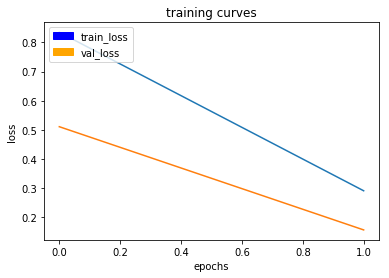


Epoch 00002: val_loss improved from 0.51055 to 0.15597, saving model to ../model/0.1560.hdf5
Epoch 3/250


INFO:plaidml:Analyzing Ops: 535 of 1594 operations complete


 1/40 [..............................] - ETA: 1:31 - loss: 0.1682

INFO:plaidml:Analyzing Ops: 1142 of 1594 operations complete


40/40 [==============================] - 37s 913ms/step - loss: 0.1060 - val_loss: 0.1002


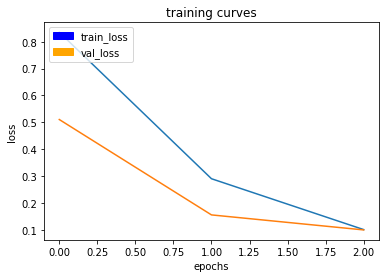


Epoch 00003: val_loss improved from 0.15597 to 0.10016, saving model to ../model/0.1002.hdf5
Epoch 4/250


INFO:plaidml:Analyzing Ops: 603 of 1594 operations complete


 1/40 [..............................] - ETA: 2:04 - loss: 0.0722

INFO:plaidml:Analyzing Ops: 545 of 1594 operations complete


40/40 [==============================] - 39s 968ms/step - loss: 0.0731 - val_loss: 0.1163


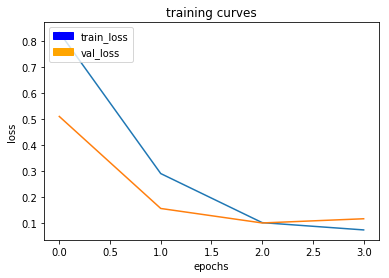


Epoch 00004: val_loss did not improve from 0.10016
Epoch 5/250
40/40 [==============================] - 32s 811ms/step - loss: 0.0559 - val_loss: 0.1163


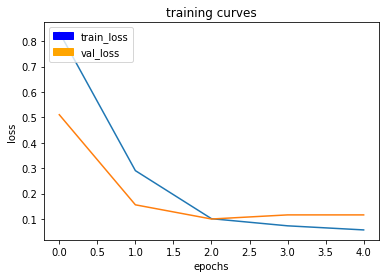


Epoch 00005: val_loss did not improve from 0.10016
Epoch 6/250
40/40 [==============================] - 32s 790ms/step - loss: 0.0549 - val_loss: 0.1208


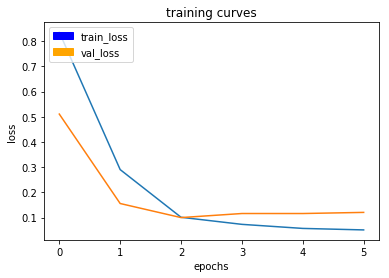


Epoch 00006: val_loss did not improve from 0.10016
Epoch 7/250
40/40 [==============================] - 32s 799ms/step - loss: 0.0436 - val_loss: 0.1195


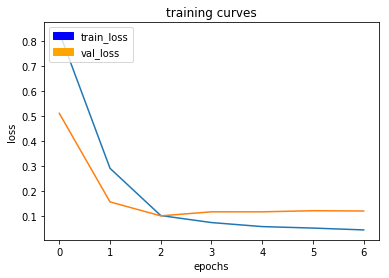


Epoch 00007: val_loss did not improve from 0.10016
Epoch 8/250
40/40 [==============================] - 32s 800ms/step - loss: 0.0405 - val_loss: 0.1151


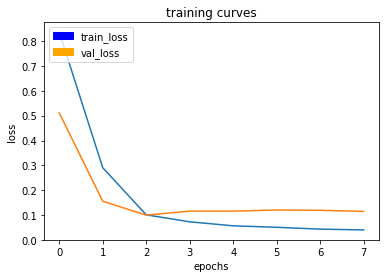


Epoch 00008: val_loss did not improve from 0.10016
Epoch 9/250
40/40 [==============================] - 33s 818ms/step - loss: 0.0429 - val_loss: 0.1001


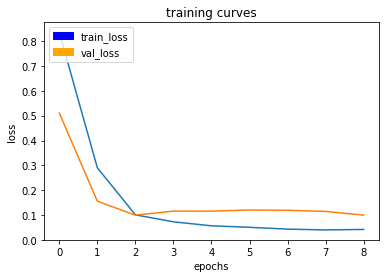


Epoch 00009: val_loss improved from 0.10016 to 0.10012, saving model to ../model/0.1001.hdf5
Epoch 10/250


INFO:plaidml:Analyzing Ops: 535 of 1594 operations complete


 1/40 [..............................] - ETA: 1:48 - loss: 0.0438

INFO:plaidml:Analyzing Ops: 603 of 1594 operations complete


40/40 [==============================] - 40s 988ms/step - loss: 0.0408 - val_loss: 0.0839


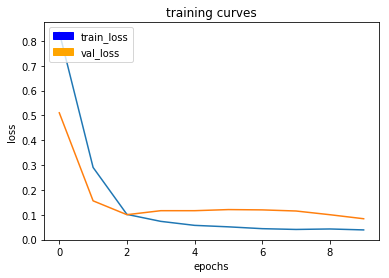


Epoch 00010: val_loss improved from 0.10012 to 0.08387, saving model to ../model/0.0839.hdf5
Epoch 11/250


INFO:plaidml:Analyzing Ops: 603 of 1594 operations complete


 4/40 [==>...........................] - ETA: 51s - loss: 0.0360 

INFO:plaidml:Analyzing Ops: 1045 of 1594 operations complete


40/40 [==============================] - 37s 930ms/step - loss: 0.0359 - val_loss: 0.0893


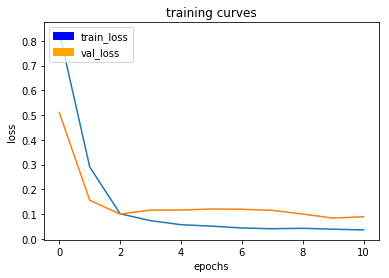


Epoch 00011: val_loss did not improve from 0.08387
Epoch 12/250
40/40 [==============================] - 32s 793ms/step - loss: 0.0336 - val_loss: 0.0835


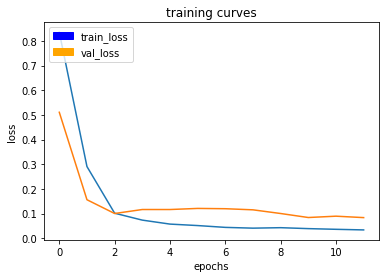


Epoch 00012: val_loss improved from 0.08387 to 0.08349, saving model to ../model/0.0835.hdf5
Epoch 13/250


INFO:plaidml:Analyzing Ops: 535 of 1594 operations complete


 4/40 [==>...........................] - ETA: 52s - loss: 0.0328 

INFO:plaidml:Analyzing Ops: 603 of 1594 operations complete


40/40 [==============================] - 38s 957ms/step - loss: 0.0323 - val_loss: 0.0822


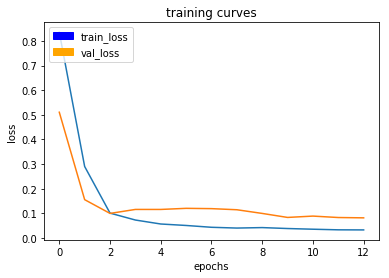


Epoch 00013: val_loss improved from 0.08349 to 0.08219, saving model to ../model/0.0822.hdf5
Epoch 14/250


INFO:plaidml:Analyzing Ops: 681 of 1594 operations complete


 4/40 [==>...........................] - ETA: 50s - loss: 0.0293

INFO:plaidml:Analyzing Ops: 535 of 1594 operations complete


40/40 [==============================] - 39s 965ms/step - loss: 0.0290 - val_loss: 0.0841


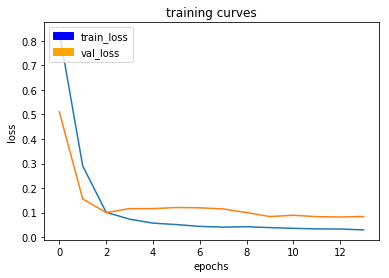


Epoch 00014: val_loss did not improve from 0.08219
Epoch 15/250
40/40 [==============================] - 34s 840ms/step - loss: 0.0289 - val_loss: 0.0780


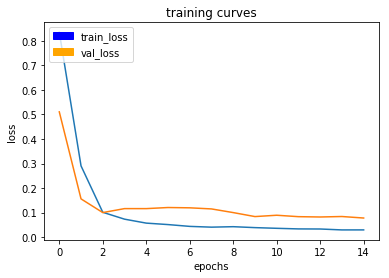


Epoch 00015: val_loss improved from 0.08219 to 0.07797, saving model to ../model/0.0780.hdf5
Epoch 16/250


INFO:plaidml:Analyzing Ops: 533 of 1594 operations complete


 1/40 [..............................] - ETA: 2:06 - loss: 0.0260

INFO:plaidml:Analyzing Ops: 1388 of 1594 operations complete


40/40 [==============================] - 38s 944ms/step - loss: 0.0368 - val_loss: 0.0923


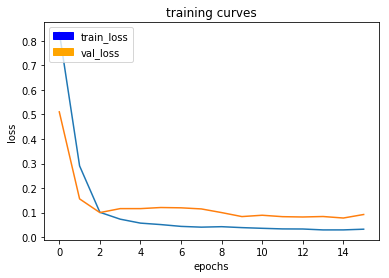


Epoch 00016: val_loss did not improve from 0.07797
Epoch 17/250
40/40 [==============================] - 33s 816ms/step - loss: 0.0286 - val_loss: 0.0957


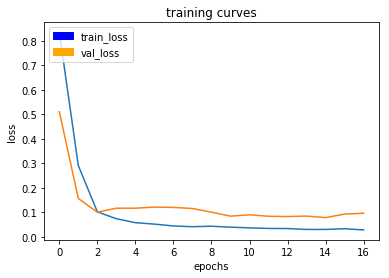


Epoch 00017: val_loss did not improve from 0.07797
Epoch 18/250
40/40 [==============================] - 32s 805ms/step - loss: 0.0274 - val_loss: 0.1117


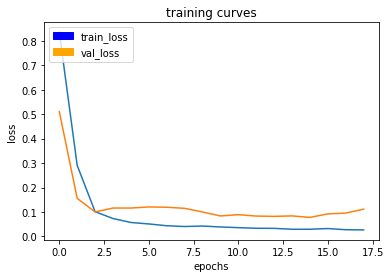


Epoch 00018: val_loss did not improve from 0.07797
Epoch 19/250
40/40 [==============================] - 33s 823ms/step - loss: 0.0280 - val_loss: 0.1247


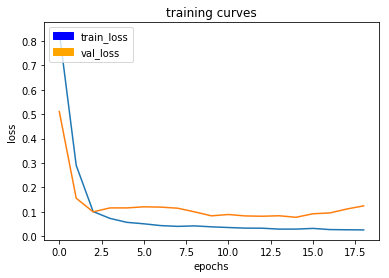


Epoch 00019: val_loss did not improve from 0.07797
Epoch 20/250
40/40 [==============================] - 33s 818ms/step - loss: 0.0305 - val_loss: 0.1328


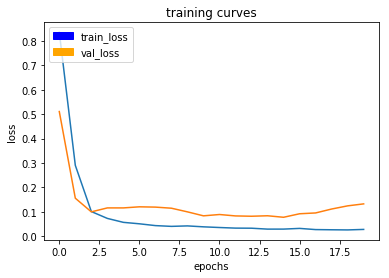


Epoch 00020: val_loss did not improve from 0.07797
Epoch 21/250
40/40 [==============================] - 33s 827ms/step - loss: 0.0287 - val_loss: 0.1633


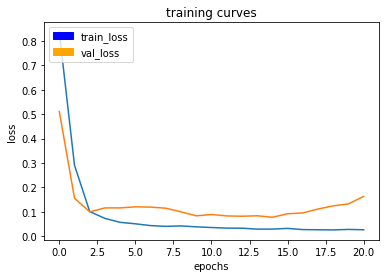


Epoch 00021: val_loss did not improve from 0.07797
Epoch 22/250
40/40 [==============================] - 30s 744ms/step - loss: 0.0270 - val_loss: 0.1232


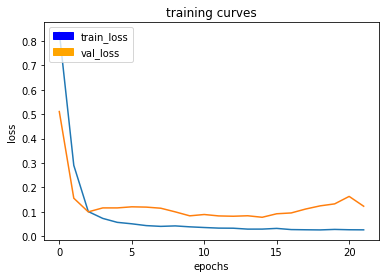


Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0035000001080334187.

Epoch 00022: val_loss did not improve from 0.07797
Epoch 23/250
40/40 [==============================] - 29s 713ms/step - loss: 0.0252 - val_loss: 0.1810


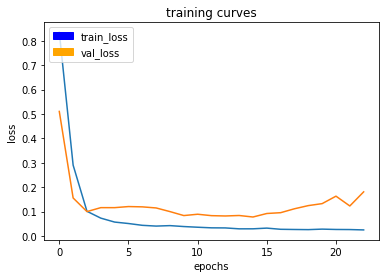


Epoch 00023: val_loss did not improve from 0.07797
Epoch 24/250
40/40 [==============================] - 29s 727ms/step - loss: 0.0229 - val_loss: 0.1009


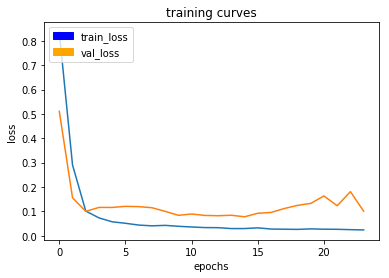


Epoch 00024: val_loss did not improve from 0.07797
Epoch 25/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0272 - val_loss: 0.1137


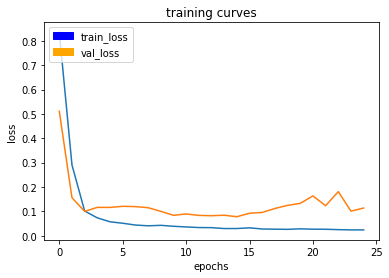


Epoch 00025: val_loss did not improve from 0.07797
Epoch 26/250
40/40 [==============================] - 29s 713ms/step - loss: 0.0249 - val_loss: 0.1408


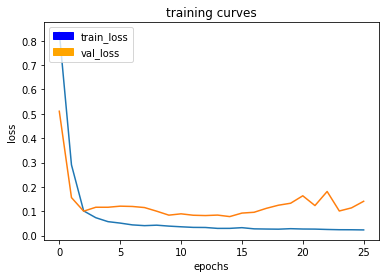


Epoch 00026: val_loss did not improve from 0.07797
Epoch 27/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0220 - val_loss: 0.1219


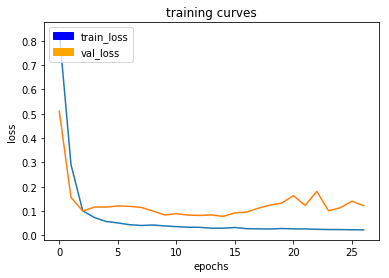


Epoch 00027: val_loss did not improve from 0.07797
Epoch 28/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0245 - val_loss: 0.2773


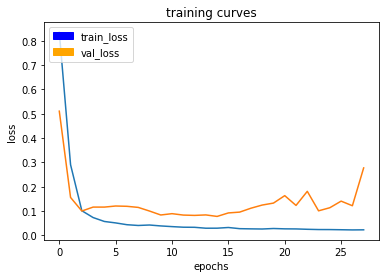


Epoch 00028: val_loss did not improve from 0.07797
Epoch 29/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0277 - val_loss: 0.1467


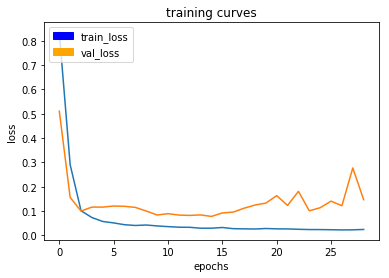


Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0017500000540167093.

Epoch 00029: val_loss did not improve from 0.07797
Epoch 30/250
40/40 [==============================] - 30s 746ms/step - loss: 0.0250 - val_loss: 0.1530


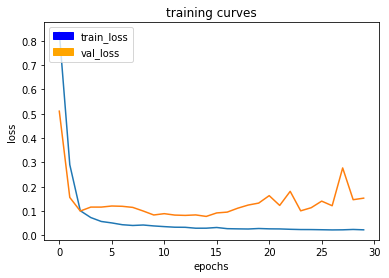


Epoch 00030: val_loss did not improve from 0.07797
Epoch 31/250
40/40 [==============================] - 30s 755ms/step - loss: 0.0232 - val_loss: 0.1188


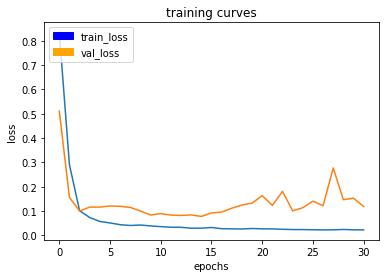


Epoch 00031: val_loss did not improve from 0.07797
Epoch 32/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0229 - val_loss: 0.1298


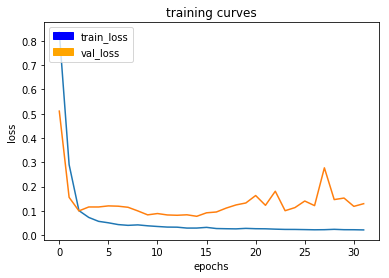


Epoch 00032: val_loss did not improve from 0.07797
Epoch 33/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0213 - val_loss: 0.1159


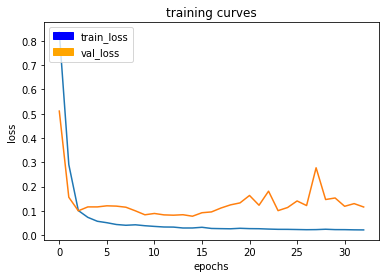


Epoch 00033: val_loss did not improve from 0.07797
Epoch 34/250
40/40 [==============================] - 30s 739ms/step - loss: 0.0244 - val_loss: 0.1450


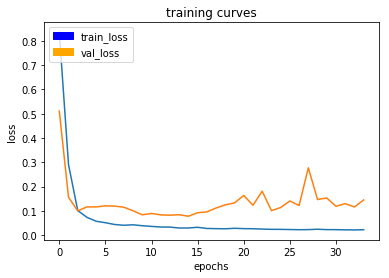


Epoch 00034: val_loss did not improve from 0.07797
Epoch 35/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0260 - val_loss: 0.1302


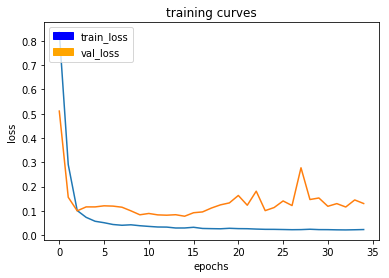


Epoch 00035: val_loss did not improve from 0.07797
Epoch 36/250
40/40 [==============================] - 30s 748ms/step - loss: 0.0212 - val_loss: 0.1209


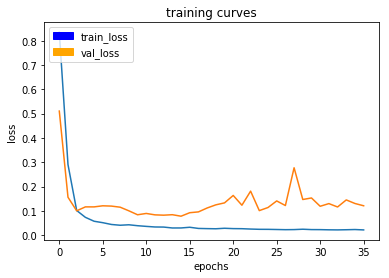


Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0008750000270083547.

Epoch 00036: val_loss did not improve from 0.07797
Epoch 37/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0221 - val_loss: 0.1394


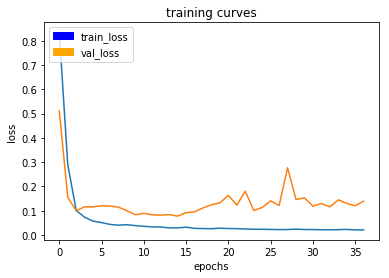


Epoch 00037: val_loss did not improve from 0.07797
Epoch 38/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0210 - val_loss: 0.1334


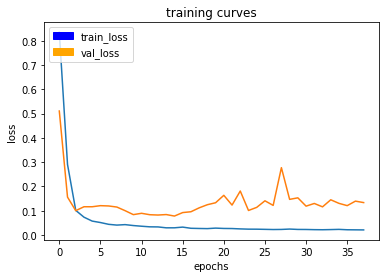


Epoch 00038: val_loss did not improve from 0.07797
Epoch 39/250
40/40 [==============================] - 29s 719ms/step - loss: 0.0204 - val_loss: 0.1295


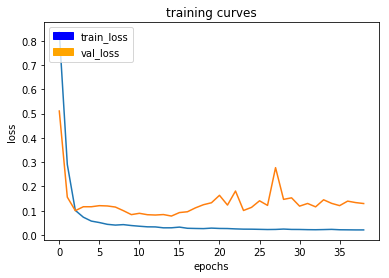


Epoch 00039: val_loss did not improve from 0.07797
Epoch 40/250
40/40 [==============================] - 30s 739ms/step - loss: 0.0209 - val_loss: 0.1543


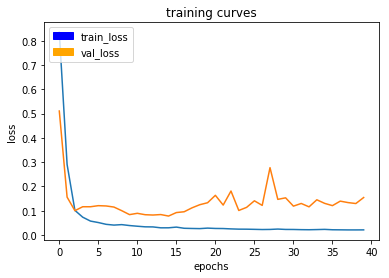


Epoch 00040: val_loss did not improve from 0.07797
Epoch 41/250
40/40 [==============================] - 30s 740ms/step - loss: 0.0209 - val_loss: 0.1493


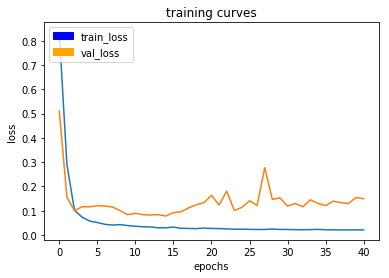


Epoch 00041: val_loss did not improve from 0.07797
Epoch 42/250
40/40 [==============================] - 30s 751ms/step - loss: 0.0238 - val_loss: 0.1772


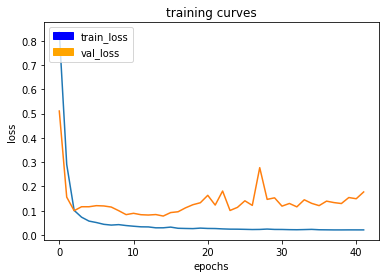


Epoch 00042: val_loss did not improve from 0.07797
Epoch 43/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0217 - val_loss: 0.1620


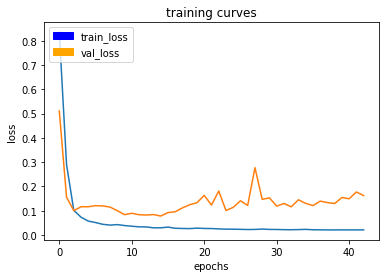


Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.00043750001350417733.

Epoch 00043: val_loss did not improve from 0.07797
Epoch 44/250
40/40 [==============================] - 29s 733ms/step - loss: 0.0234 - val_loss: 0.1662


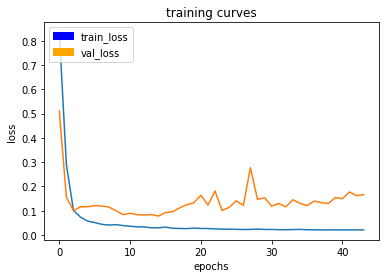


Epoch 00044: val_loss did not improve from 0.07797
Epoch 45/250
40/40 [==============================] - 29s 721ms/step - loss: 0.0205 - val_loss: 0.1524


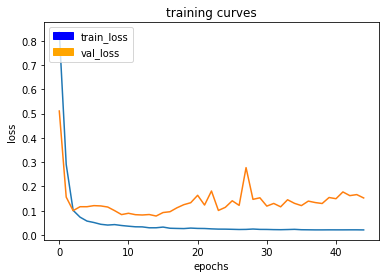


Epoch 00045: val_loss did not improve from 0.07797
Epoch 46/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0232 - val_loss: 0.1417


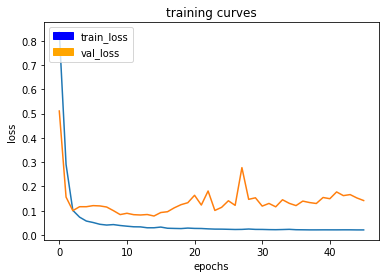


Epoch 00046: val_loss did not improve from 0.07797
Epoch 47/250
40/40 [==============================] - 30s 751ms/step - loss: 0.0211 - val_loss: 0.1622


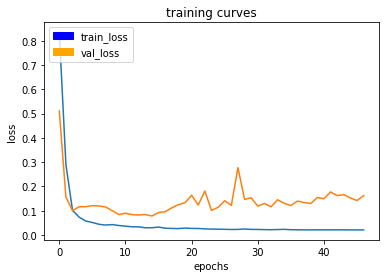


Epoch 00047: val_loss did not improve from 0.07797
Epoch 48/250
40/40 [==============================] - 30s 745ms/step - loss: 0.0211 - val_loss: 0.1550


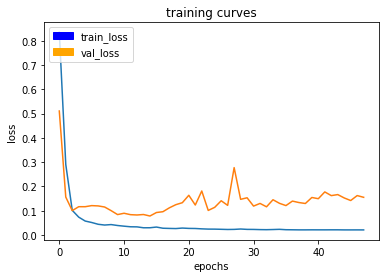


Epoch 00048: val_loss did not improve from 0.07797
Epoch 49/250
40/40 [==============================] - 29s 714ms/step - loss: 0.0210 - val_loss: 0.1453


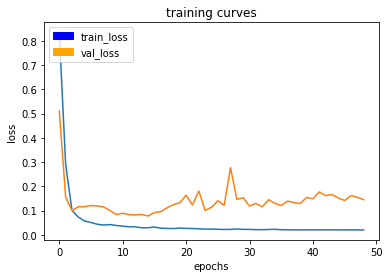


Epoch 00049: val_loss did not improve from 0.07797
Epoch 50/250
40/40 [==============================] - 29s 723ms/step - loss: 0.0212 - val_loss: 0.1539


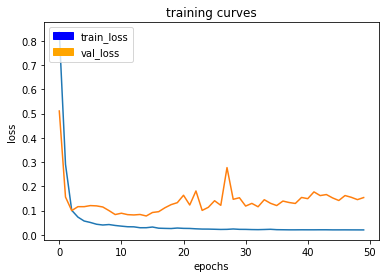


Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.00021875000675208867.

Epoch 00050: val_loss did not improve from 0.07797
Epoch 51/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0220 - val_loss: 0.1569


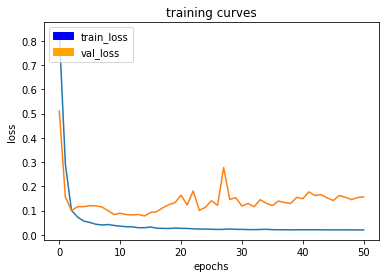


Epoch 00051: val_loss did not improve from 0.07797
Epoch 52/250
40/40 [==============================] - 29s 731ms/step - loss: 0.0211 - val_loss: 0.1702


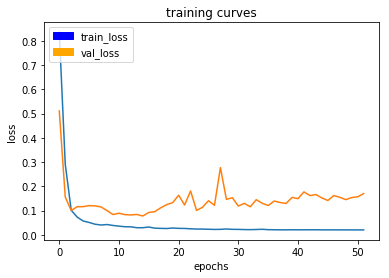


Epoch 00052: val_loss did not improve from 0.07797
Epoch 53/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0209 - val_loss: 0.1638


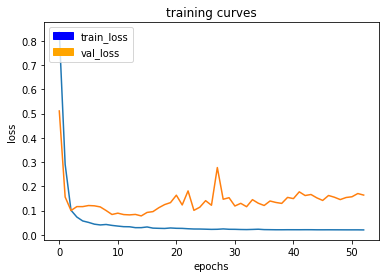


Epoch 00053: val_loss did not improve from 0.07797
Epoch 54/250
40/40 [==============================] - 30s 761ms/step - loss: 0.0238 - val_loss: 0.1579


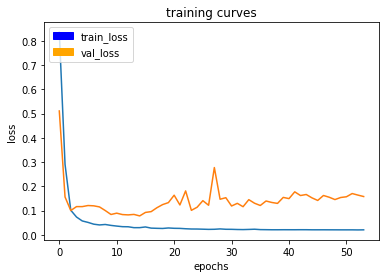


Epoch 00054: val_loss did not improve from 0.07797
Epoch 55/250
40/40 [==============================] - 29s 737ms/step - loss: 0.0196 - val_loss: 0.1528


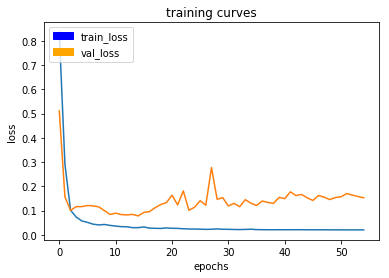


Epoch 00055: val_loss did not improve from 0.07797
Epoch 56/250
40/40 [==============================] - 29s 728ms/step - loss: 0.0235 - val_loss: 0.1564


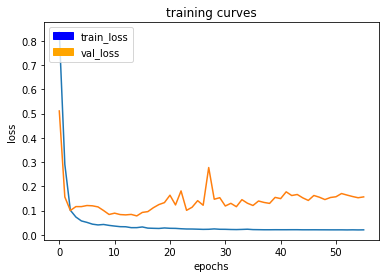


Epoch 00056: val_loss did not improve from 0.07797
Epoch 57/250
40/40 [==============================] - 29s 713ms/step - loss: 0.0205 - val_loss: 0.1659


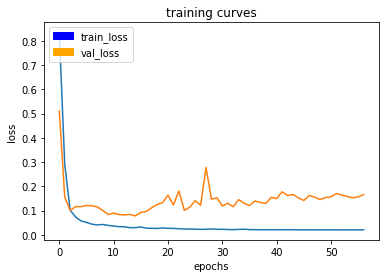


Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00010937500337604433.

Epoch 00057: val_loss did not improve from 0.07797
Epoch 58/250
40/40 [==============================] - 29s 727ms/step - loss: 0.0202 - val_loss: 0.1585


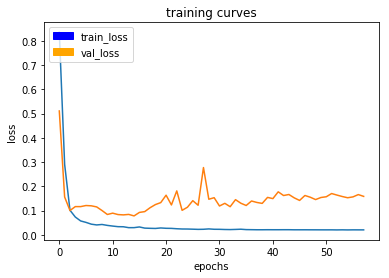


Epoch 00058: val_loss did not improve from 0.07797
Epoch 59/250
40/40 [==============================] - 29s 717ms/step - loss: 0.0199 - val_loss: 0.1568


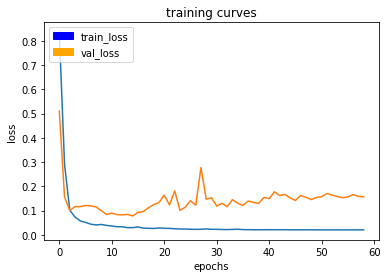


Epoch 00059: val_loss did not improve from 0.07797
Epoch 60/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0211 - val_loss: 0.1591


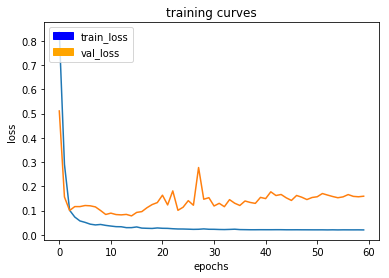


Epoch 00060: val_loss did not improve from 0.07797
Epoch 61/250
40/40 [==============================] - 31s 765ms/step - loss: 0.0201 - val_loss: 0.1568


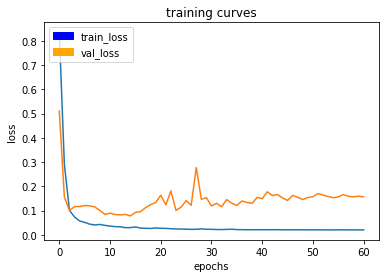


Epoch 00061: val_loss did not improve from 0.07797
Epoch 62/250
40/40 [==============================] - 30s 741ms/step - loss: 0.0206 - val_loss: 0.1560


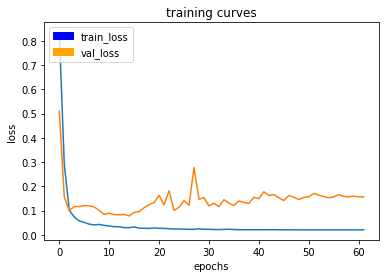


Epoch 00062: val_loss did not improve from 0.07797
Epoch 63/250
40/40 [==============================] - 30s 743ms/step - loss: 0.0197 - val_loss: 0.1563


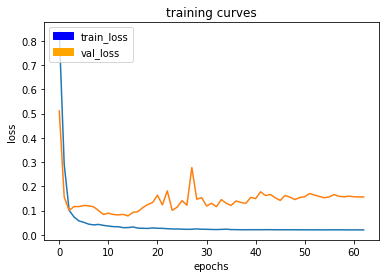


Epoch 00063: val_loss did not improve from 0.07797
Epoch 64/250
40/40 [==============================] - 29s 723ms/step - loss: 0.0201 - val_loss: 0.1593


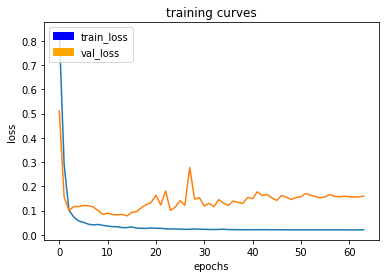


Epoch 00064: ReduceLROnPlateau reducing learning rate to 5.4687501688022166e-05.

Epoch 00064: val_loss did not improve from 0.07797
Epoch 65/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0283 - val_loss: 0.1596


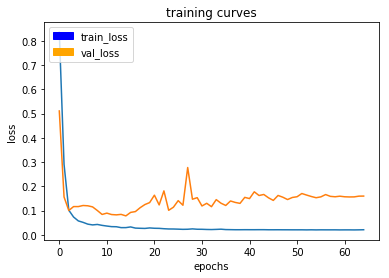


Epoch 00065: val_loss did not improve from 0.07797
Epoch 66/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0216 - val_loss: 0.1598


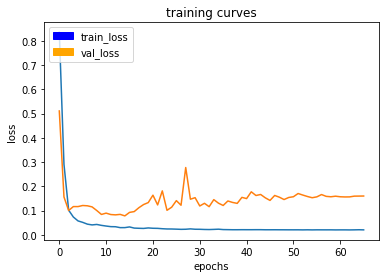


Epoch 00066: val_loss did not improve from 0.07797
Epoch 67/250
40/40 [==============================] - 29s 718ms/step - loss: 0.0212 - val_loss: 0.1582


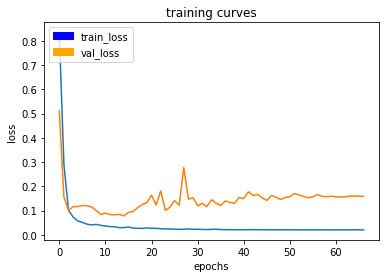


Epoch 00067: val_loss did not improve from 0.07797
Epoch 68/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0212 - val_loss: 0.1595


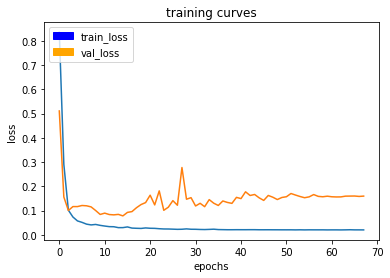


Epoch 00068: val_loss did not improve from 0.07797
Epoch 69/250
40/40 [==============================] - 29s 736ms/step - loss: 0.0211 - val_loss: 0.1586


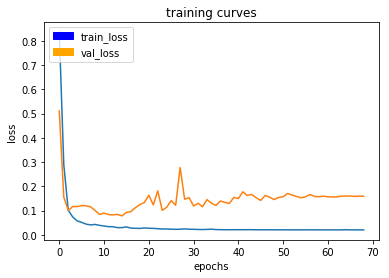


Epoch 00069: val_loss did not improve from 0.07797
Epoch 70/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0207 - val_loss: 0.1569


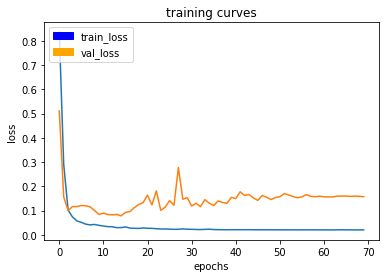


Epoch 00070: val_loss did not improve from 0.07797
Epoch 71/250
40/40 [==============================] - 30s 747ms/step - loss: 0.0205 - val_loss: 0.1566


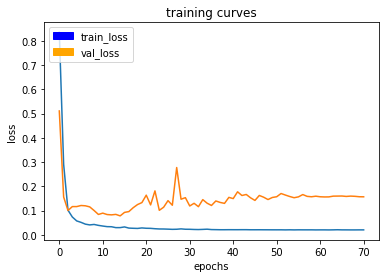


Epoch 00071: ReduceLROnPlateau reducing learning rate to 2.7343750844011083e-05.

Epoch 00071: val_loss did not improve from 0.07797
Epoch 72/250
40/40 [==============================] - 29s 731ms/step - loss: 0.0198 - val_loss: 0.1571


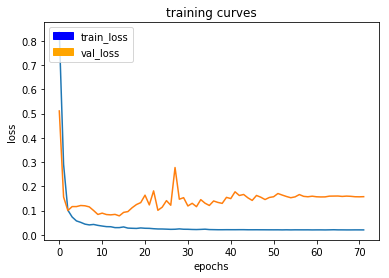


Epoch 00072: val_loss did not improve from 0.07797
Epoch 73/250
40/40 [==============================] - 29s 728ms/step - loss: 0.0213 - val_loss: 0.1557


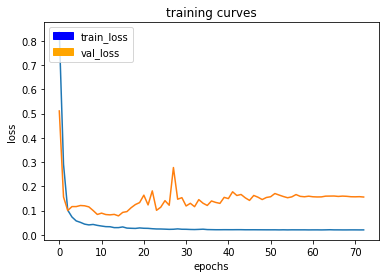


Epoch 00073: val_loss did not improve from 0.07797
Epoch 74/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0229 - val_loss: 0.1545


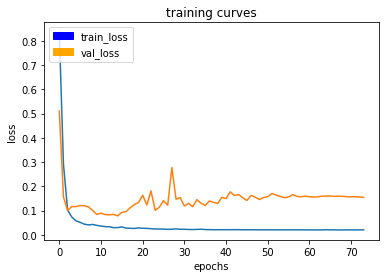


Epoch 00074: val_loss did not improve from 0.07797
Epoch 75/250
40/40 [==============================] - 30s 746ms/step - loss: 0.0199 - val_loss: 0.1562


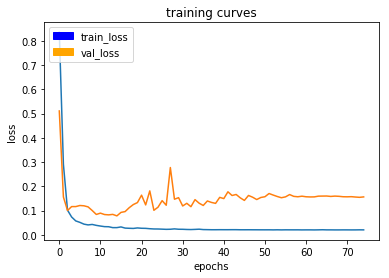


Epoch 00075: val_loss did not improve from 0.07797
Epoch 76/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0223 - val_loss: 0.1565


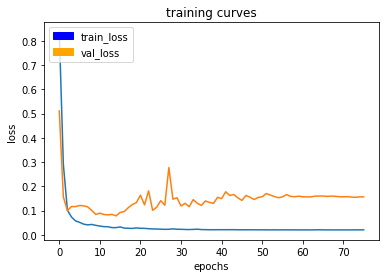


Epoch 00076: val_loss did not improve from 0.07797
Epoch 77/250
40/40 [==============================] - 30s 759ms/step - loss: 0.0246 - val_loss: 0.1560


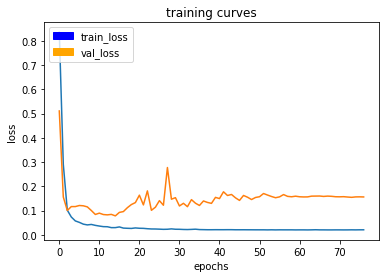


Epoch 00077: val_loss did not improve from 0.07797
Epoch 78/250
40/40 [==============================] - 30s 747ms/step - loss: 0.0218 - val_loss: 0.1552


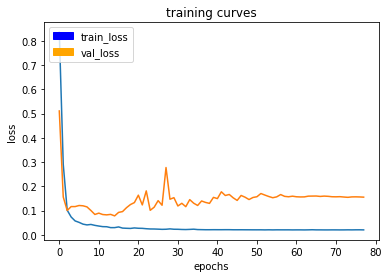


Epoch 00078: ReduceLROnPlateau reducing learning rate to 1.3671875422005542e-05.

Epoch 00078: val_loss did not improve from 0.07797
Epoch 79/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0202 - val_loss: 0.1573


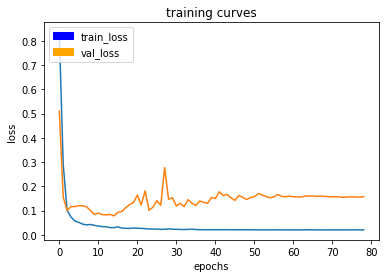


Epoch 00079: val_loss did not improve from 0.07797
Epoch 80/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0219 - val_loss: 0.1558


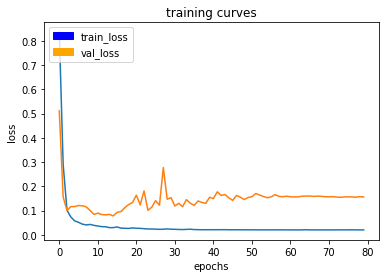


Epoch 00080: val_loss did not improve from 0.07797
Epoch 81/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0204 - val_loss: 0.1575


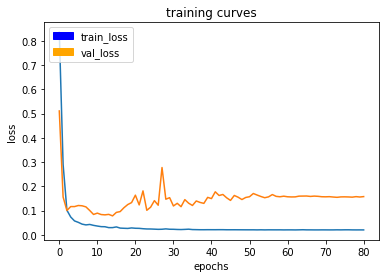


Epoch 00081: val_loss did not improve from 0.07797
Epoch 82/250
40/40 [==============================] - 29s 728ms/step - loss: 0.0209 - val_loss: 0.1586


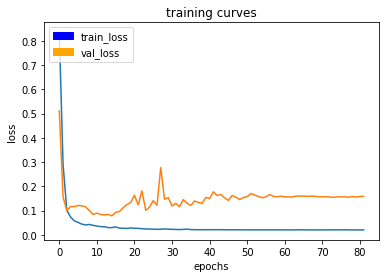


Epoch 00082: val_loss did not improve from 0.07797
Epoch 83/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0209 - val_loss: 0.1593


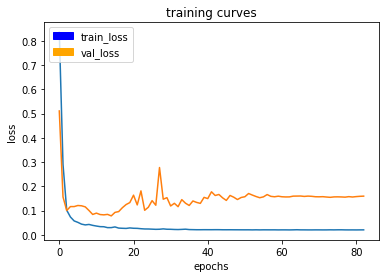


Epoch 00083: val_loss did not improve from 0.07797
Epoch 84/250
40/40 [==============================] - 29s 714ms/step - loss: 0.0201 - val_loss: 0.1593


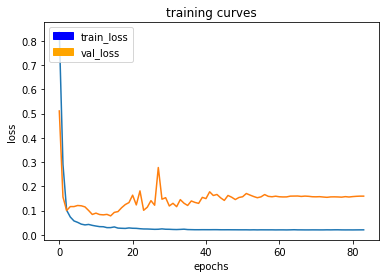


Epoch 00084: val_loss did not improve from 0.07797
Epoch 85/250
40/40 [==============================] - 30s 741ms/step - loss: 0.0233 - val_loss: 0.1582


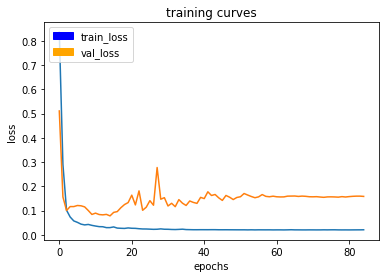


Epoch 00085: ReduceLROnPlateau reducing learning rate to 6.835937711002771e-06.

Epoch 00085: val_loss did not improve from 0.07797
Epoch 86/250
40/40 [==============================] - 29s 719ms/step - loss: 0.0209 - val_loss: 0.1588


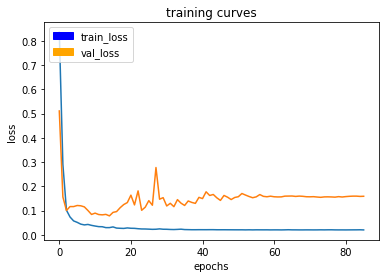


Epoch 00086: val_loss did not improve from 0.07797
Epoch 87/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0206 - val_loss: 0.1598


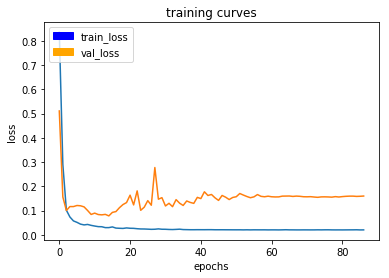


Epoch 00087: val_loss did not improve from 0.07797
Epoch 88/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0215 - val_loss: 0.1604


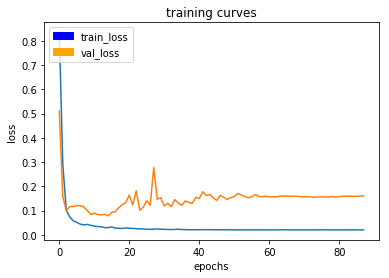


Epoch 00088: val_loss did not improve from 0.07797
Epoch 89/250
40/40 [==============================] - 30s 741ms/step - loss: 0.0209 - val_loss: 0.1592


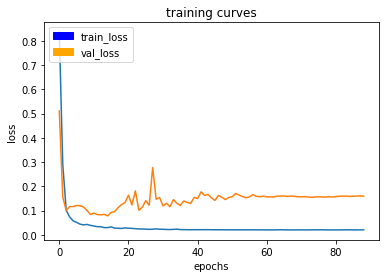


Epoch 00089: val_loss did not improve from 0.07797
Epoch 90/250
40/40 [==============================] - 30s 748ms/step - loss: 0.0207 - val_loss: 0.1601


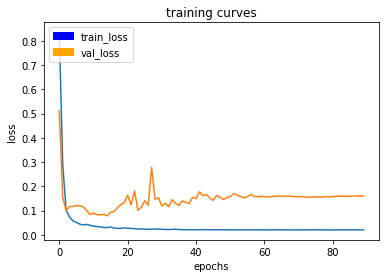


Epoch 00090: val_loss did not improve from 0.07797
Epoch 91/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0251 - val_loss: 0.1577


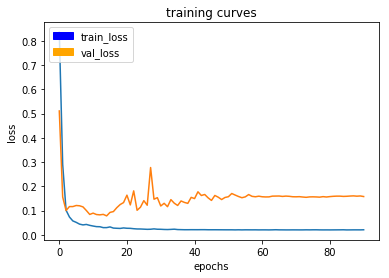


Epoch 00091: val_loss did not improve from 0.07797
Epoch 92/250
40/40 [==============================] - 29s 736ms/step - loss: 0.0217 - val_loss: 0.1578


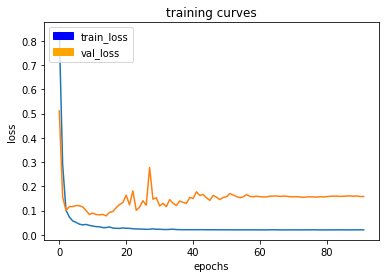


Epoch 00092: ReduceLROnPlateau reducing learning rate to 3.4179688555013854e-06.

Epoch 00092: val_loss did not improve from 0.07797
Epoch 93/250
40/40 [==============================] - 29s 736ms/step - loss: 0.0198 - val_loss: 0.1592


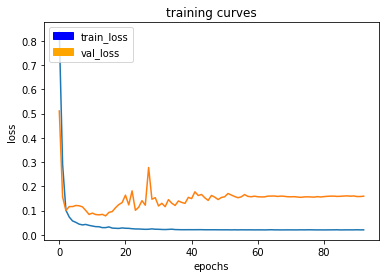


Epoch 00093: val_loss did not improve from 0.07797
Epoch 94/250
40/40 [==============================] - 30s 745ms/step - loss: 0.0212 - val_loss: 0.1590


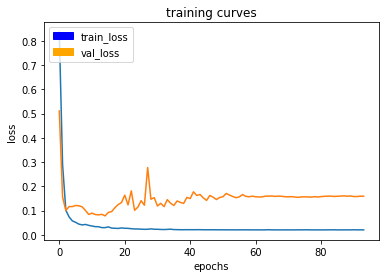


Epoch 00094: val_loss did not improve from 0.07797
Epoch 95/250
40/40 [==============================] - 30s 745ms/step - loss: 0.0208 - val_loss: 0.1594


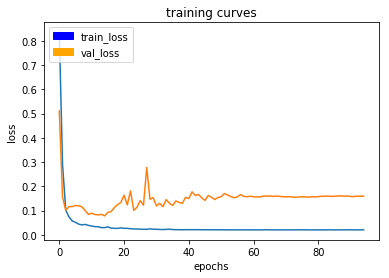


Epoch 00095: val_loss did not improve from 0.07797
Epoch 96/250
40/40 [==============================] - 29s 737ms/step - loss: 0.0206 - val_loss: 0.1598


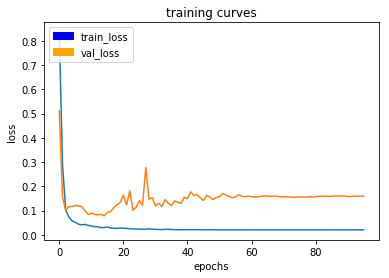


Epoch 00096: val_loss did not improve from 0.07797
Epoch 97/250
40/40 [==============================] - 29s 721ms/step - loss: 0.0221 - val_loss: 0.1574


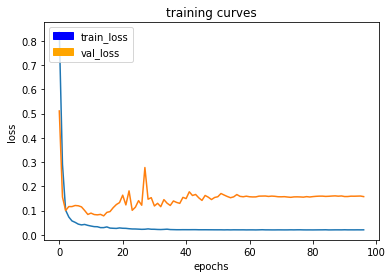


Epoch 00097: val_loss did not improve from 0.07797
Epoch 98/250
40/40 [==============================] - 29s 727ms/step - loss: 0.0204 - val_loss: 0.1566


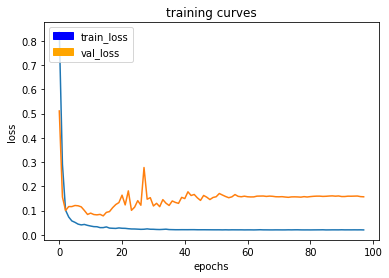


Epoch 00098: val_loss did not improve from 0.07797
Epoch 99/250
40/40 [==============================] - 29s 718ms/step - loss: 0.0228 - val_loss: 0.1539


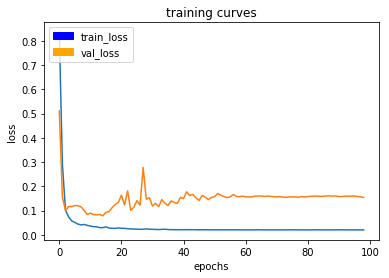


Epoch 00099: ReduceLROnPlateau reducing learning rate to 1.7089844277506927e-06.

Epoch 00099: val_loss did not improve from 0.07797
Epoch 100/250
40/40 [==============================] - 29s 729ms/step - loss: 0.0230 - val_loss: 0.1548


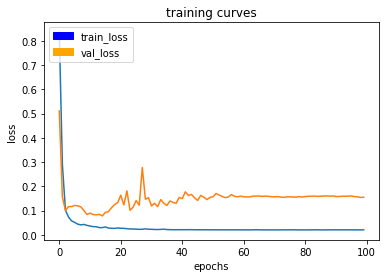


Epoch 00100: val_loss did not improve from 0.07797
Epoch 101/250
40/40 [==============================] - 28s 711ms/step - loss: 0.0214 - val_loss: 0.1554


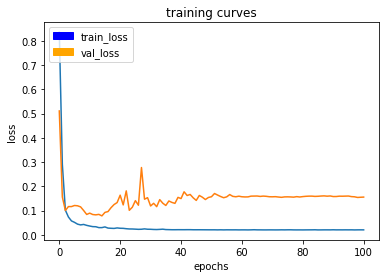


Epoch 00101: val_loss did not improve from 0.07797
Epoch 102/250
40/40 [==============================] - 29s 735ms/step - loss: 0.0221 - val_loss: 0.1550


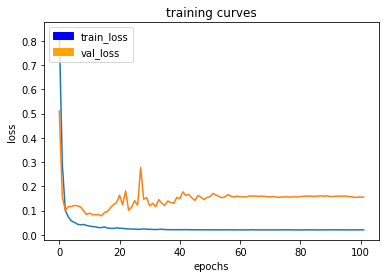


Epoch 00102: val_loss did not improve from 0.07797
Epoch 103/250
40/40 [==============================] - 30s 739ms/step - loss: 0.0218 - val_loss: 0.1552


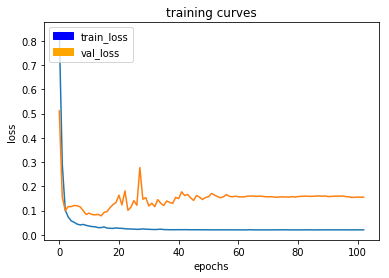


Epoch 00103: val_loss did not improve from 0.07797
Epoch 104/250
40/40 [==============================] - 29s 713ms/step - loss: 0.0212 - val_loss: 0.1563


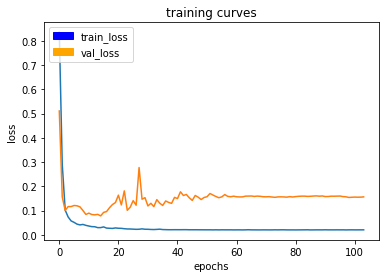


Epoch 00104: val_loss did not improve from 0.07797
Epoch 105/250
40/40 [==============================] - 30s 744ms/step - loss: 0.0212 - val_loss: 0.1573


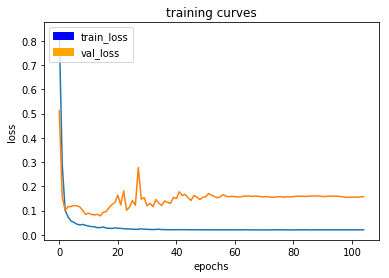


Epoch 00105: val_loss did not improve from 0.07797
Epoch 106/250
40/40 [==============================] - 29s 729ms/step - loss: 0.0223 - val_loss: 0.1567


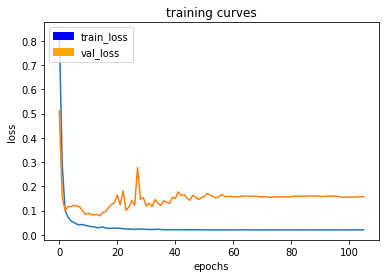


Epoch 00106: ReduceLROnPlateau reducing learning rate to 8.544922138753464e-07.

Epoch 00106: val_loss did not improve from 0.07797
Epoch 107/250
40/40 [==============================] - 29s 723ms/step - loss: 0.0237 - val_loss: 0.1538


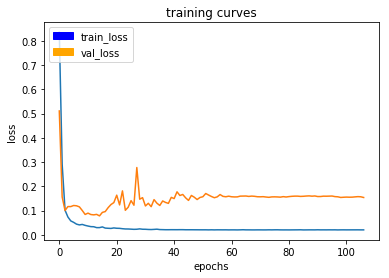


Epoch 00107: val_loss did not improve from 0.07797
Epoch 108/250
40/40 [==============================] - 30s 739ms/step - loss: 0.0220 - val_loss: 0.1563


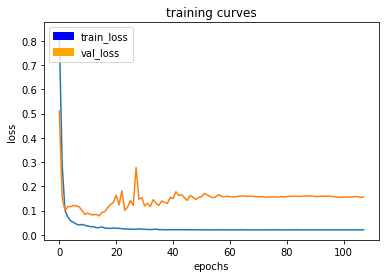


Epoch 00108: val_loss did not improve from 0.07797
Epoch 109/250
40/40 [==============================] - 30s 754ms/step - loss: 0.0196 - val_loss: 0.1593


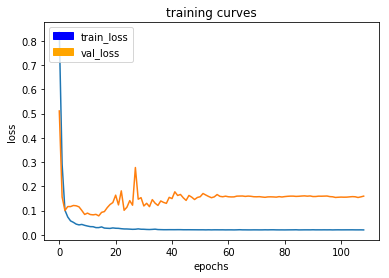


Epoch 00109: val_loss did not improve from 0.07797
Epoch 110/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0216 - val_loss: 0.1590


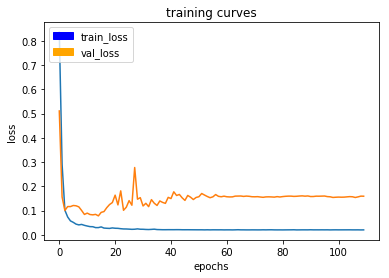


Epoch 00110: val_loss did not improve from 0.07797
Epoch 111/250
40/40 [==============================] - 29s 717ms/step - loss: 0.0197 - val_loss: 0.1600


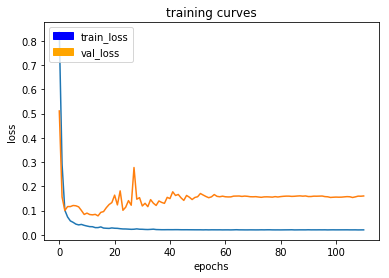


Epoch 00111: val_loss did not improve from 0.07797
Epoch 112/250
40/40 [==============================] - 30s 743ms/step - loss: 0.0233 - val_loss: 0.1595


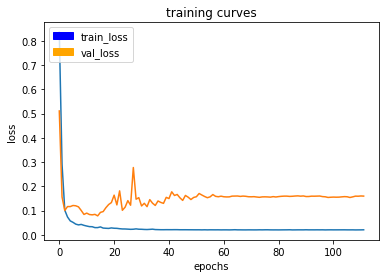


Epoch 00112: val_loss did not improve from 0.07797
Epoch 113/250
40/40 [==============================] - 29s 718ms/step - loss: 0.0204 - val_loss: 0.1591


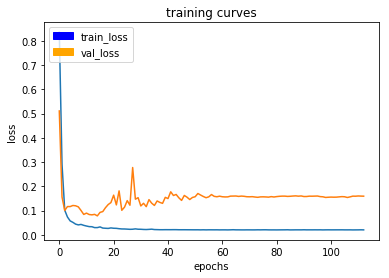


Epoch 00113: ReduceLROnPlateau reducing learning rate to 4.272461069376732e-07.

Epoch 00113: val_loss did not improve from 0.07797
Epoch 114/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0208 - val_loss: 0.1589


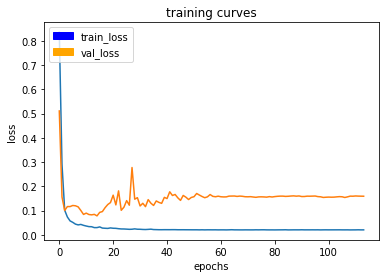


Epoch 00114: val_loss did not improve from 0.07797
Epoch 115/250
40/40 [==============================] - 30s 749ms/step - loss: 0.0204 - val_loss: 0.1591


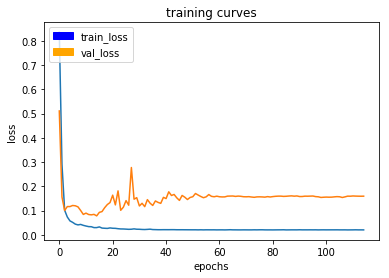


Epoch 00115: val_loss did not improve from 0.07797
Epoch 116/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0222 - val_loss: 0.1592


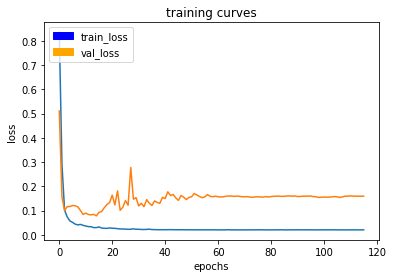


Epoch 00116: val_loss did not improve from 0.07797
Epoch 117/250
40/40 [==============================] - 29s 728ms/step - loss: 0.0203 - val_loss: 0.1614


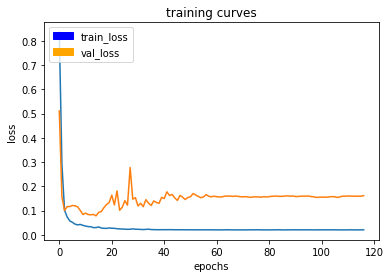


Epoch 00117: val_loss did not improve from 0.07797
Epoch 118/250
40/40 [==============================] - 30s 746ms/step - loss: 0.0230 - val_loss: 0.1599


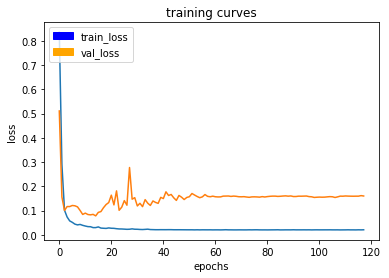


Epoch 00118: val_loss did not improve from 0.07797
Epoch 119/250
40/40 [==============================] - 29s 724ms/step - loss: 0.0218 - val_loss: 0.1592


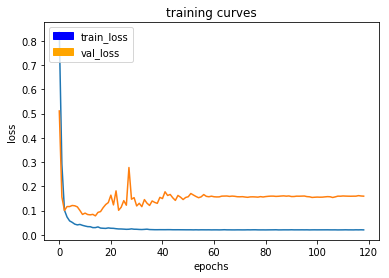


Epoch 00119: val_loss did not improve from 0.07797
Epoch 120/250
40/40 [==============================] - 30s 741ms/step - loss: 0.0229 - val_loss: 0.1581


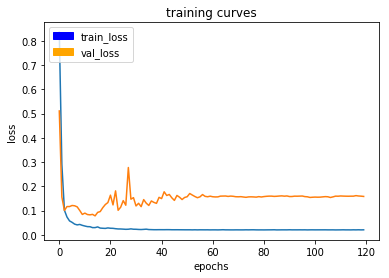


Epoch 00120: ReduceLROnPlateau reducing learning rate to 2.136230534688366e-07.

Epoch 00120: val_loss did not improve from 0.07797
Epoch 121/250
40/40 [==============================] - 30s 762ms/step - loss: 0.0220 - val_loss: 0.1571


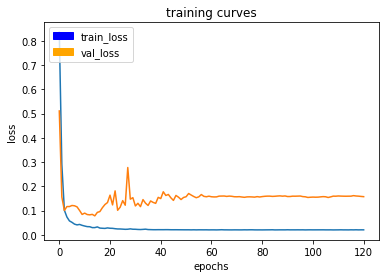


Epoch 00121: val_loss did not improve from 0.07797
Epoch 122/250
40/40 [==============================] - 29s 731ms/step - loss: 0.0203 - val_loss: 0.1588


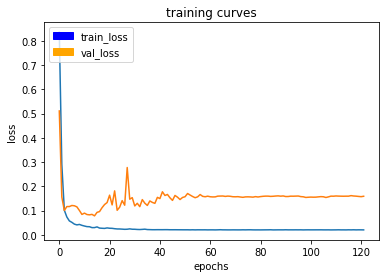


Epoch 00122: val_loss did not improve from 0.07797
Epoch 123/250
40/40 [==============================] - 30s 743ms/step - loss: 0.0209 - val_loss: 0.1593


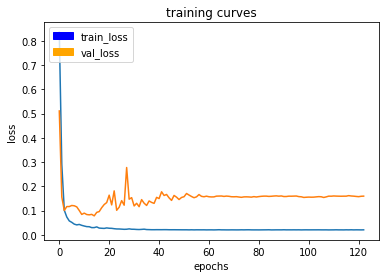


Epoch 00123: val_loss did not improve from 0.07797
Epoch 124/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0207 - val_loss: 0.1587


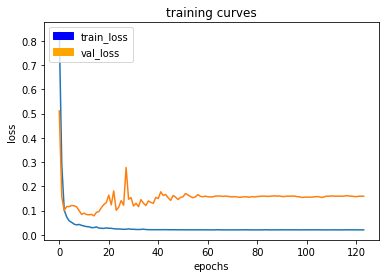


Epoch 00124: val_loss did not improve from 0.07797
Epoch 125/250
40/40 [==============================] - 29s 735ms/step - loss: 0.0225 - val_loss: 0.1569


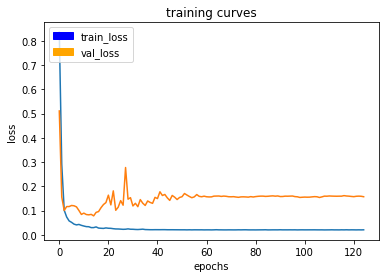


Epoch 00125: val_loss did not improve from 0.07797
Epoch 126/250
40/40 [==============================] - 30s 738ms/step - loss: 0.0228 - val_loss: 0.1576


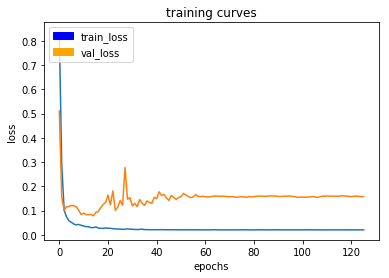


Epoch 00126: val_loss did not improve from 0.07797
Epoch 127/250
40/40 [==============================] - 29s 736ms/step - loss: 0.0201 - val_loss: 0.1587


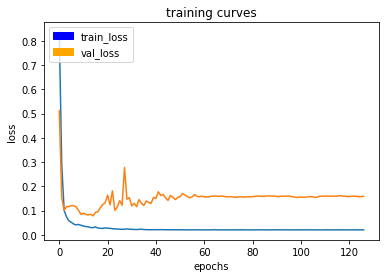


Epoch 00127: ReduceLROnPlateau reducing learning rate to 1.068115267344183e-07.

Epoch 00127: val_loss did not improve from 0.07797
Epoch 128/250
40/40 [==============================] - 29s 715ms/step - loss: 0.0197 - val_loss: 0.1611


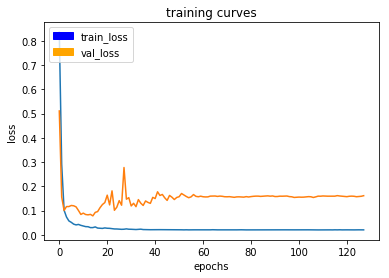


Epoch 00128: val_loss did not improve from 0.07797
Epoch 129/250
40/40 [==============================] - 29s 727ms/step - loss: 0.0216 - val_loss: 0.1592


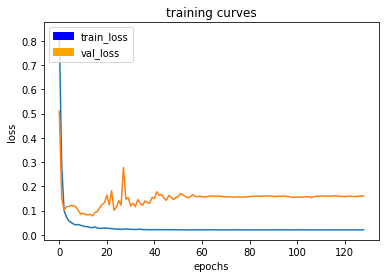


Epoch 00129: val_loss did not improve from 0.07797
Epoch 130/250
40/40 [==============================] - 30s 745ms/step - loss: 0.0276 - val_loss: 0.1535


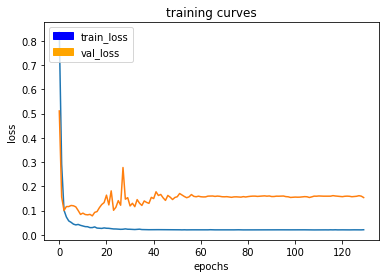


Epoch 00130: val_loss did not improve from 0.07797
Epoch 131/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0206 - val_loss: 0.1558


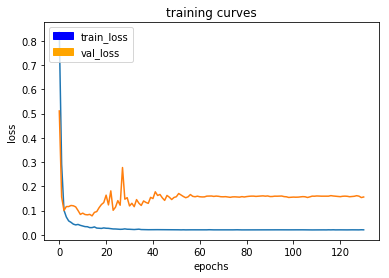


Epoch 00131: val_loss did not improve from 0.07797
Epoch 132/250
40/40 [==============================] - 30s 754ms/step - loss: 0.0198 - val_loss: 0.1589


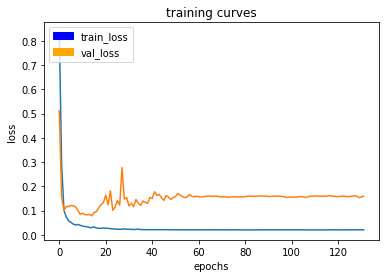


Epoch 00132: val_loss did not improve from 0.07797
Epoch 133/250
40/40 [==============================] - 31s 777ms/step - loss: 0.0213 - val_loss: 0.1573


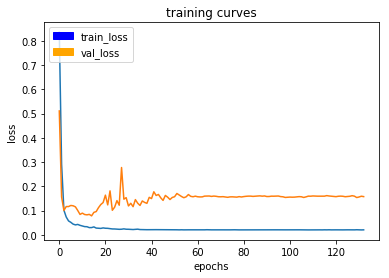


Epoch 00133: val_loss did not improve from 0.07797
Epoch 134/250
40/40 [==============================] - 30s 749ms/step - loss: 0.0206 - val_loss: 0.1598


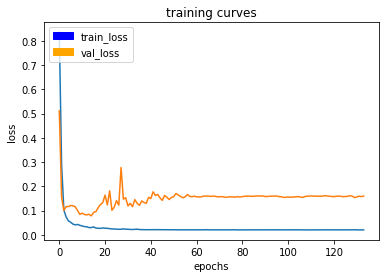


Epoch 00134: ReduceLROnPlateau reducing learning rate to 5.340576336720915e-08.

Epoch 00134: val_loss did not improve from 0.07797
Epoch 135/250
40/40 [==============================] - 29s 719ms/step - loss: 0.0209 - val_loss: 0.1593


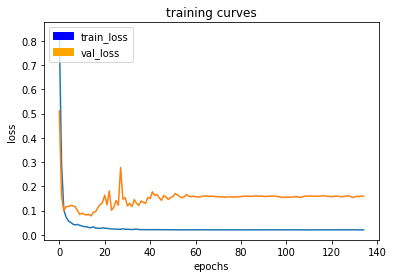


Epoch 00135: val_loss did not improve from 0.07797
Epoch 136/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0201 - val_loss: 0.1606


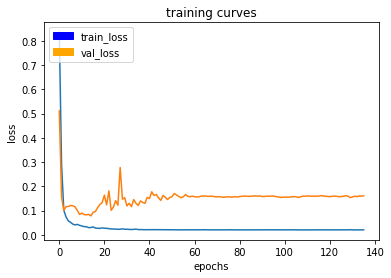


Epoch 00136: val_loss did not improve from 0.07797
Epoch 137/250
40/40 [==============================] - 29s 717ms/step - loss: 0.0205 - val_loss: 0.1599


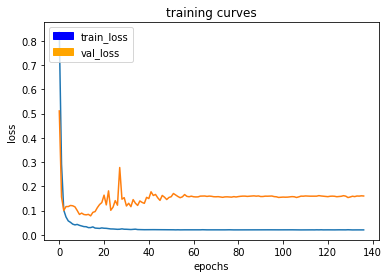


Epoch 00137: val_loss did not improve from 0.07797
Epoch 138/250
40/40 [==============================] - 29s 724ms/step - loss: 0.0197 - val_loss: 0.1608


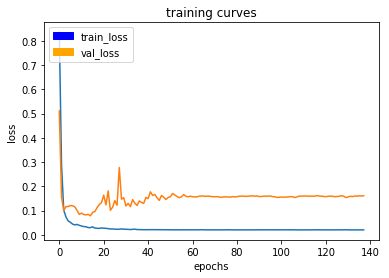


Epoch 00138: val_loss did not improve from 0.07797
Epoch 139/250
40/40 [==============================] - 29s 734ms/step - loss: 0.0216 - val_loss: 0.1595


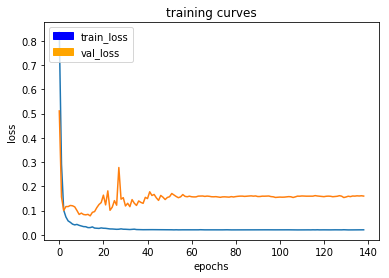


Epoch 00139: val_loss did not improve from 0.07797
Epoch 140/250
40/40 [==============================] - 30s 743ms/step - loss: 0.0210 - val_loss: 0.1589


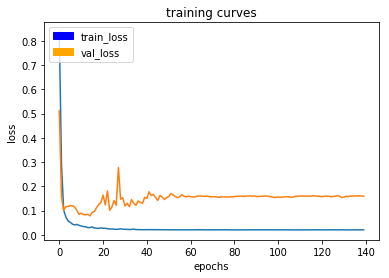


Epoch 00140: val_loss did not improve from 0.07797
Epoch 141/250
40/40 [==============================] - 29s 734ms/step - loss: 0.0206 - val_loss: 0.1602


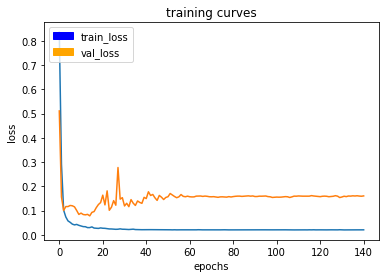


Epoch 00141: ReduceLROnPlateau reducing learning rate to 2.6702881683604573e-08.

Epoch 00141: val_loss did not improve from 0.07797
Epoch 142/250
40/40 [==============================] - 29s 718ms/step - loss: 0.0208 - val_loss: 0.1596


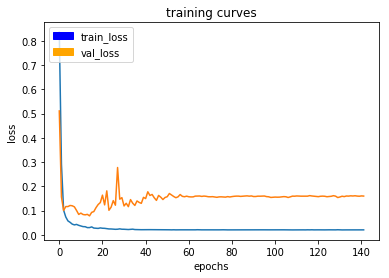


Epoch 00142: val_loss did not improve from 0.07797
Epoch 143/250
40/40 [==============================] - 30s 747ms/step - loss: 0.0200 - val_loss: 0.1586


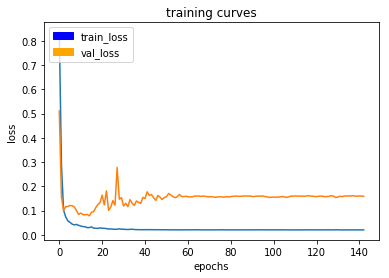


Epoch 00143: val_loss did not improve from 0.07797
Epoch 144/250
40/40 [==============================] - 29s 721ms/step - loss: 0.0206 - val_loss: 0.1586


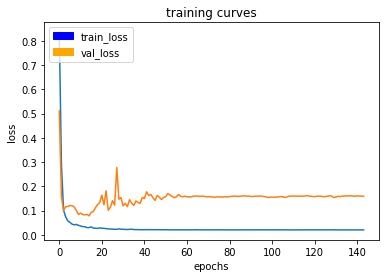


Epoch 00144: val_loss did not improve from 0.07797
Epoch 145/250
40/40 [==============================] - 31s 766ms/step - loss: 0.0215 - val_loss: 0.1581


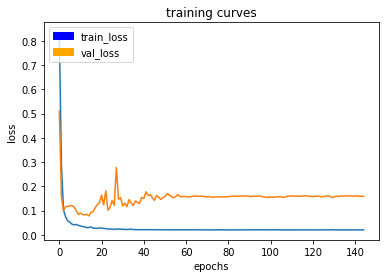


Epoch 00145: val_loss did not improve from 0.07797
Epoch 146/250
40/40 [==============================] - 29s 726ms/step - loss: 0.0202 - val_loss: 0.1600


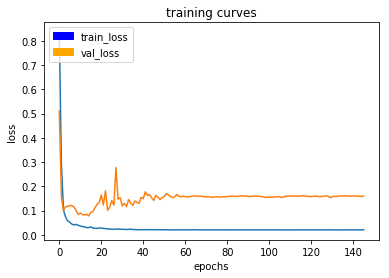


Epoch 00146: val_loss did not improve from 0.07797
Epoch 147/250
40/40 [==============================] - 29s 729ms/step - loss: 0.0204 - val_loss: 0.1607


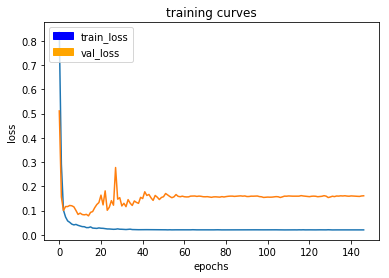


Epoch 00147: val_loss did not improve from 0.07797
Epoch 148/250
40/40 [==============================] - 29s 731ms/step - loss: 0.0230 - val_loss: 0.1580


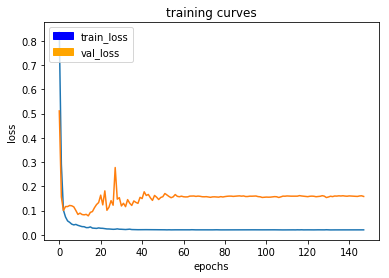


Epoch 00148: ReduceLROnPlateau reducing learning rate to 1.3351440841802287e-08.

Epoch 00148: val_loss did not improve from 0.07797
Epoch 149/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0264 - val_loss: 0.1558


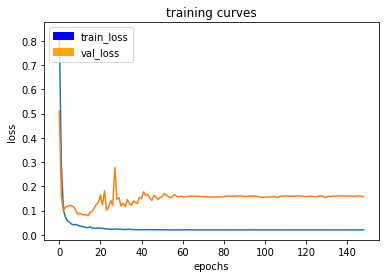


Epoch 00149: val_loss did not improve from 0.07797
Epoch 150/250
40/40 [==============================] - 30s 744ms/step - loss: 0.0210 - val_loss: 0.1567


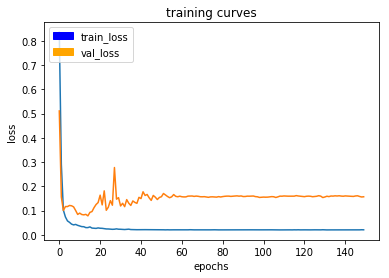


Epoch 00150: val_loss did not improve from 0.07797
Epoch 151/250
40/40 [==============================] - 29s 736ms/step - loss: 0.0257 - val_loss: 0.1531


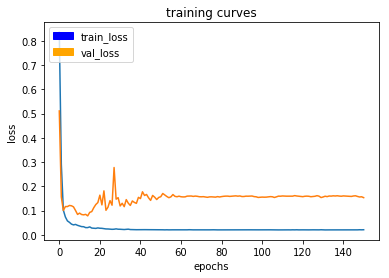


Epoch 00151: val_loss did not improve from 0.07797
Epoch 152/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0203 - val_loss: 0.1550


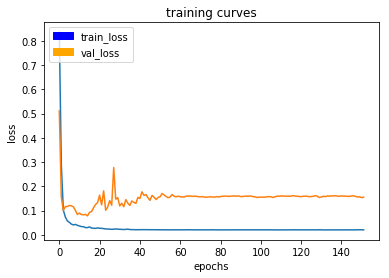


Epoch 00152: val_loss did not improve from 0.07797
Epoch 153/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0216 - val_loss: 0.1546


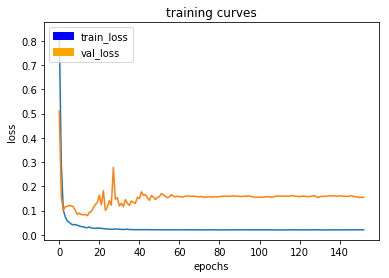


Epoch 00153: val_loss did not improve from 0.07797
Epoch 154/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0218 - val_loss: 0.1563


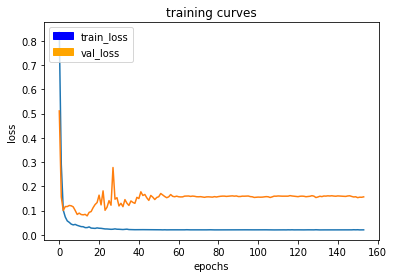


Epoch 00154: val_loss did not improve from 0.07797
Epoch 155/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0201 - val_loss: 0.1590


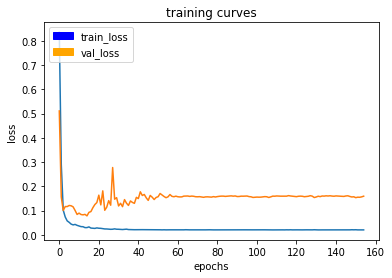


Epoch 00155: ReduceLROnPlateau reducing learning rate to 6.675720420901143e-09.

Epoch 00155: val_loss did not improve from 0.07797
Epoch 156/250
40/40 [==============================] - 30s 751ms/step - loss: 0.0215 - val_loss: 0.1594


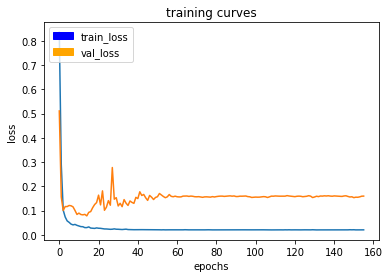


Epoch 00156: val_loss did not improve from 0.07797
Epoch 157/250
40/40 [==============================] - 30s 741ms/step - loss: 0.0210 - val_loss: 0.1580


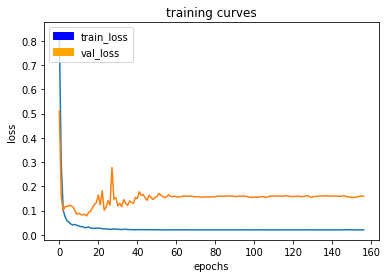


Epoch 00157: val_loss did not improve from 0.07797
Epoch 158/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0205 - val_loss: 0.1592


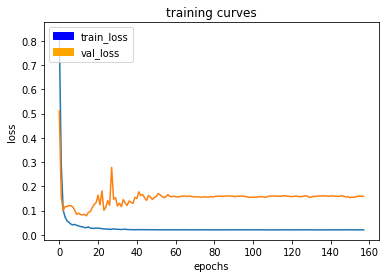


Epoch 00158: val_loss did not improve from 0.07797
Epoch 159/250
40/40 [==============================] - 29s 727ms/step - loss: 0.0250 - val_loss: 0.1593


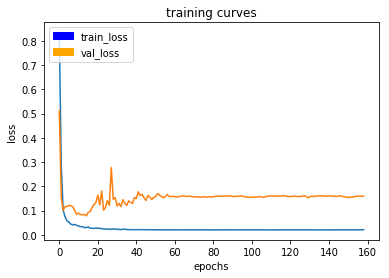


Epoch 00159: val_loss did not improve from 0.07797
Epoch 160/250
40/40 [==============================] - 30s 747ms/step - loss: 0.0201 - val_loss: 0.1588


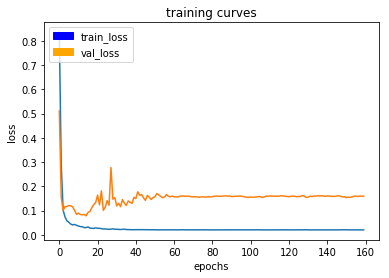


Epoch 00160: val_loss did not improve from 0.07797
Epoch 161/250
40/40 [==============================] - 30s 747ms/step - loss: 0.0197 - val_loss: 0.1611


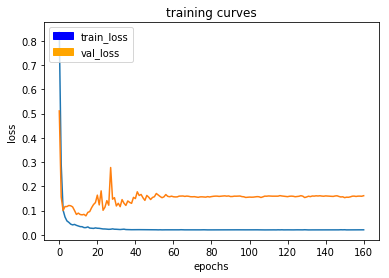


Epoch 00161: val_loss did not improve from 0.07797
Epoch 162/250
40/40 [==============================] - 30s 754ms/step - loss: 0.0230 - val_loss: 0.1566


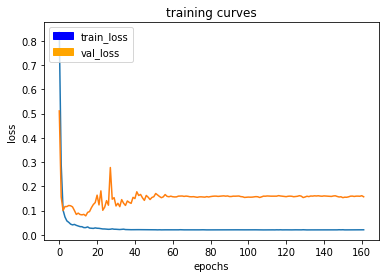


Epoch 00162: ReduceLROnPlateau reducing learning rate to 3.3378602104505717e-09.

Epoch 00162: val_loss did not improve from 0.07797
Epoch 163/250
40/40 [==============================] - 30s 738ms/step - loss: 0.0221 - val_loss: 0.1545


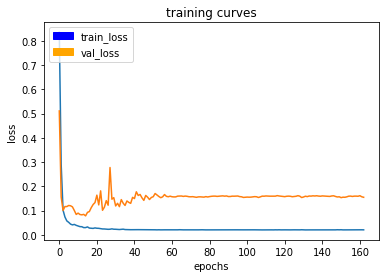


Epoch 00163: val_loss did not improve from 0.07797
Epoch 164/250
40/40 [==============================] - 30s 749ms/step - loss: 0.0205 - val_loss: 0.1559


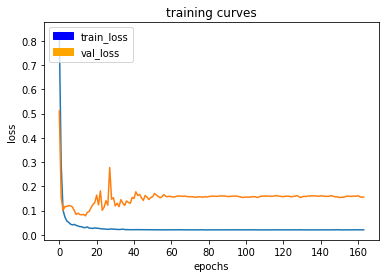


Epoch 00164: val_loss did not improve from 0.07797
Epoch 165/250
40/40 [==============================] - 30s 755ms/step - loss: 0.0220 - val_loss: 0.1567


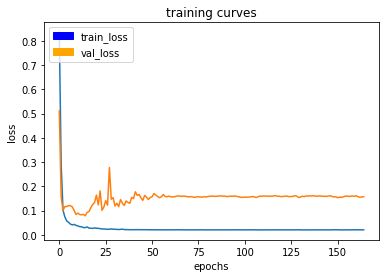


Epoch 00165: val_loss did not improve from 0.07797
Epoch 166/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0210 - val_loss: 0.1563


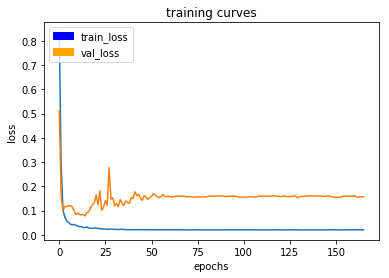


Epoch 00166: val_loss did not improve from 0.07797
Epoch 167/250
40/40 [==============================] - 29s 727ms/step - loss: 0.0198 - val_loss: 0.1585


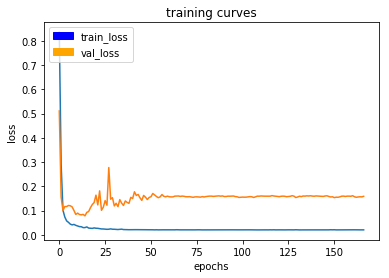


Epoch 00167: val_loss did not improve from 0.07797
Epoch 168/250
40/40 [==============================] - 29s 735ms/step - loss: 0.0200 - val_loss: 0.1594


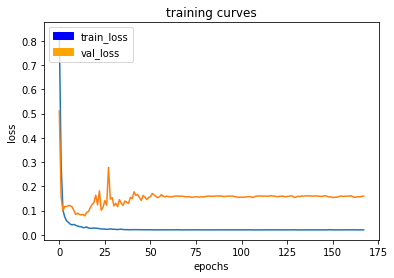


Epoch 00168: val_loss did not improve from 0.07797
Epoch 169/250
40/40 [==============================] - 29s 725ms/step - loss: 0.0223 - val_loss: 0.1565


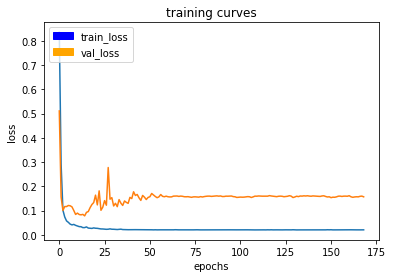


Epoch 00169: ReduceLROnPlateau reducing learning rate to 1.6689301052252858e-09.

Epoch 00169: val_loss did not improve from 0.07797
Epoch 170/250
40/40 [==============================] - 30s 740ms/step - loss: 0.0246 - val_loss: 0.1537


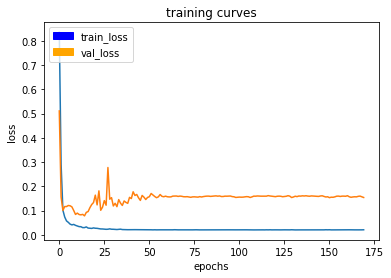


Epoch 00170: val_loss did not improve from 0.07797
Epoch 171/250
40/40 [==============================] - 29s 729ms/step - loss: 0.0224 - val_loss: 0.1551


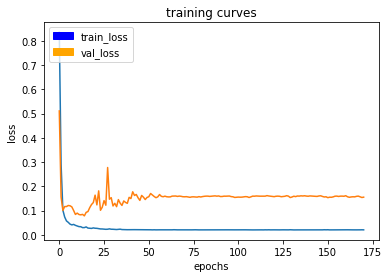


Epoch 00171: val_loss did not improve from 0.07797
Epoch 172/250
40/40 [==============================] - 30s 756ms/step - loss: 0.0218 - val_loss: 0.1553


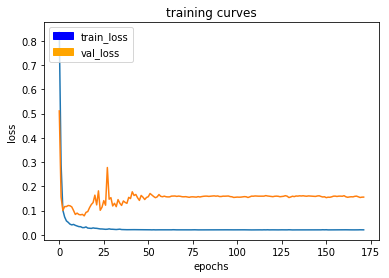


Epoch 00172: val_loss did not improve from 0.07797
Epoch 173/250
40/40 [==============================] - 29s 729ms/step - loss: 0.0213 - val_loss: 0.1573


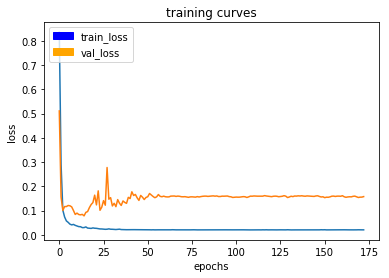


Epoch 00173: val_loss did not improve from 0.07797
Epoch 174/250
40/40 [==============================] - 30s 738ms/step - loss: 0.0205 - val_loss: 0.1588


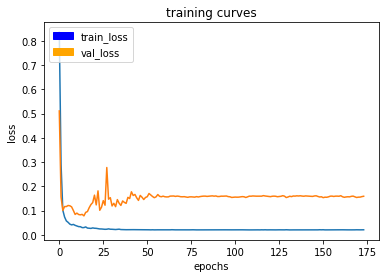


Epoch 00174: val_loss did not improve from 0.07797
Epoch 175/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0275 - val_loss: 0.1553


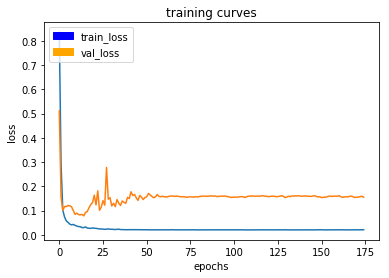


Epoch 00175: val_loss did not improve from 0.07797
Epoch 176/250
40/40 [==============================] - 30s 754ms/step - loss: 0.0198 - val_loss: 0.1584


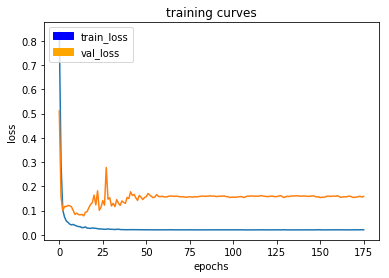


Epoch 00176: ReduceLROnPlateau reducing learning rate to 8.344650526126429e-10.

Epoch 00176: val_loss did not improve from 0.07797
Epoch 177/250
40/40 [==============================] - 29s 728ms/step - loss: 0.0196 - val_loss: 0.1604


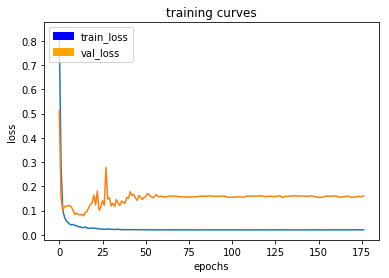


Epoch 00177: val_loss did not improve from 0.07797
Epoch 178/250
40/40 [==============================] - 29s 735ms/step - loss: 0.0203 - val_loss: 0.1612


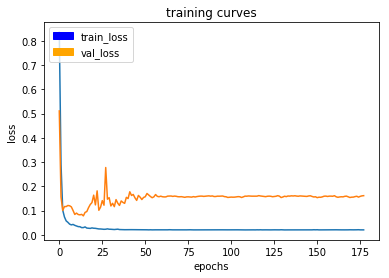


Epoch 00178: val_loss did not improve from 0.07797
Epoch 179/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0211 - val_loss: 0.1598


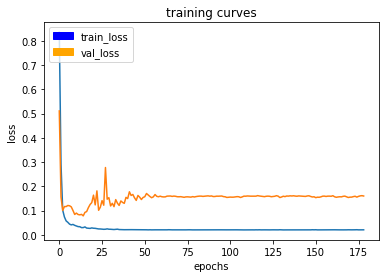


Epoch 00179: val_loss did not improve from 0.07797
Epoch 180/250
40/40 [==============================] - 29s 723ms/step - loss: 0.0205 - val_loss: 0.1601


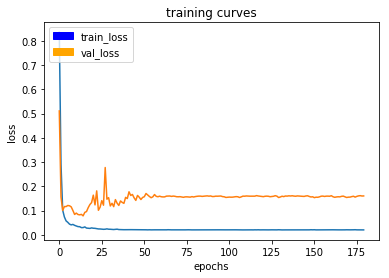


Epoch 00180: val_loss did not improve from 0.07797
Epoch 181/250
40/40 [==============================] - 30s 753ms/step - loss: 0.0204 - val_loss: 0.1611


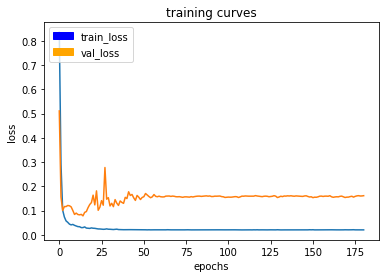


Epoch 00181: val_loss did not improve from 0.07797
Epoch 182/250
40/40 [==============================] - 29s 735ms/step - loss: 0.0202 - val_loss: 0.1621


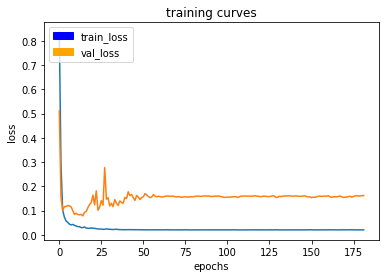


Epoch 00182: val_loss did not improve from 0.07797
Epoch 183/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0207 - val_loss: 0.1598


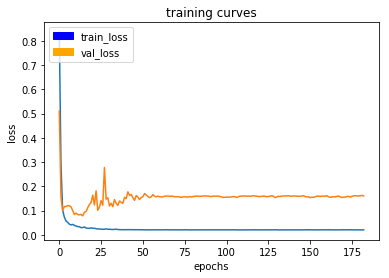


Epoch 00183: ReduceLROnPlateau reducing learning rate to 4.1723252630632146e-10.

Epoch 00183: val_loss did not improve from 0.07797
Epoch 184/250
40/40 [==============================] - 29s 736ms/step - loss: 0.0261 - val_loss: 0.1563


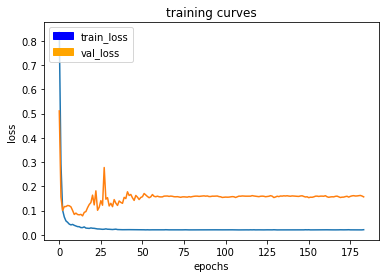


Epoch 00184: val_loss did not improve from 0.07797
Epoch 185/250
40/40 [==============================] - 30s 743ms/step - loss: 0.0210 - val_loss: 0.1554


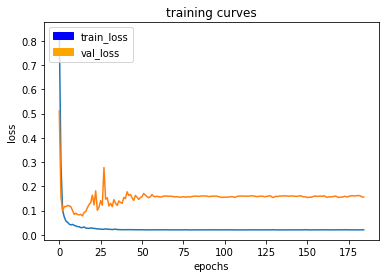


Epoch 00185: val_loss did not improve from 0.07797
Epoch 186/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0220 - val_loss: 0.1554


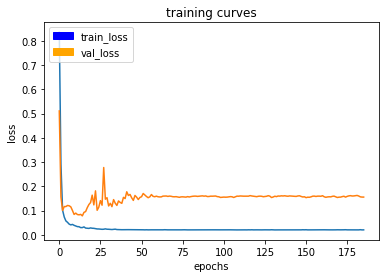


Epoch 00186: val_loss did not improve from 0.07797
Epoch 187/250
40/40 [==============================] - 29s 737ms/step - loss: 0.0209 - val_loss: 0.1584


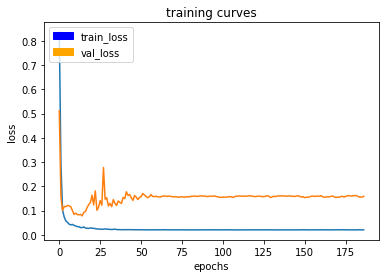


Epoch 00187: val_loss did not improve from 0.07797
Epoch 188/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0231 - val_loss: 0.1560


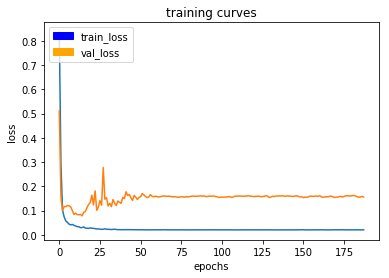


Epoch 00188: val_loss did not improve from 0.07797
Epoch 189/250
40/40 [==============================] - 29s 723ms/step - loss: 0.0203 - val_loss: 0.1587


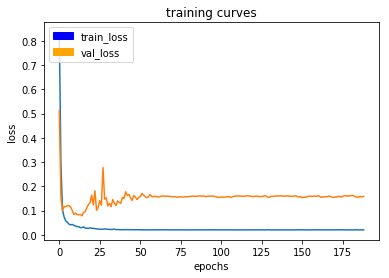


Epoch 00189: val_loss did not improve from 0.07797
Epoch 190/250
40/40 [==============================] - 30s 754ms/step - loss: 0.0211 - val_loss: 0.1586


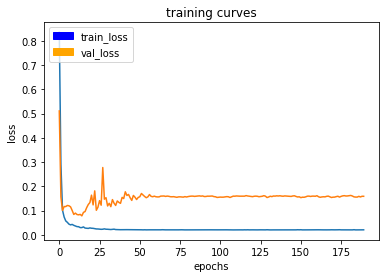


Epoch 00190: ReduceLROnPlateau reducing learning rate to 2.0861626315316073e-10.

Epoch 00190: val_loss did not improve from 0.07797
Epoch 191/250
40/40 [==============================] - 30s 740ms/step - loss: 0.0224 - val_loss: 0.1572


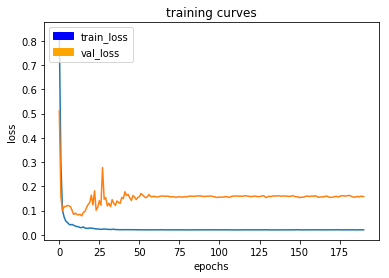


Epoch 00191: val_loss did not improve from 0.07797
Epoch 192/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0215 - val_loss: 0.1576


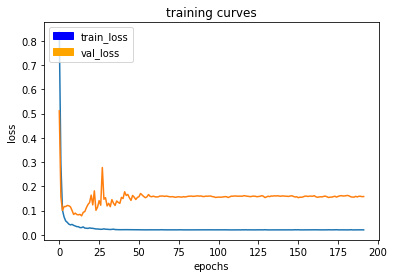


Epoch 00192: val_loss did not improve from 0.07797
Epoch 193/250
40/40 [==============================] - 30s 741ms/step - loss: 0.0225 - val_loss: 0.1570


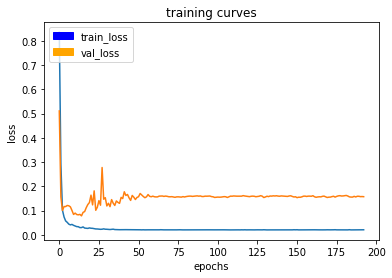


Epoch 00193: val_loss did not improve from 0.07797
Epoch 194/250
40/40 [==============================] - 30s 741ms/step - loss: 0.0222 - val_loss: 0.1562


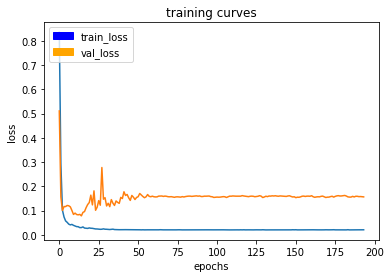


Epoch 00194: val_loss did not improve from 0.07797
Epoch 195/250
40/40 [==============================] - 29s 724ms/step - loss: 0.0204 - val_loss: 0.1569


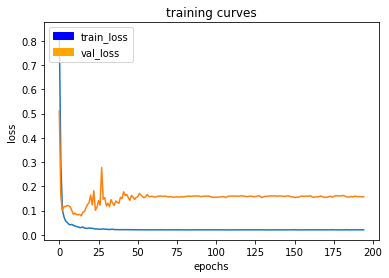


Epoch 00195: val_loss did not improve from 0.07797
Epoch 196/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0208 - val_loss: 0.1567


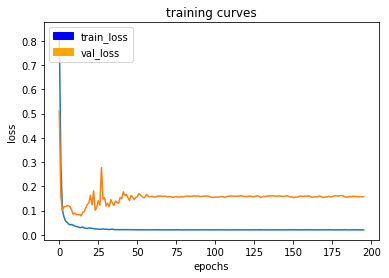


Epoch 00196: val_loss did not improve from 0.07797
Epoch 197/250
40/40 [==============================] - 29s 728ms/step - loss: 0.0213 - val_loss: 0.1548


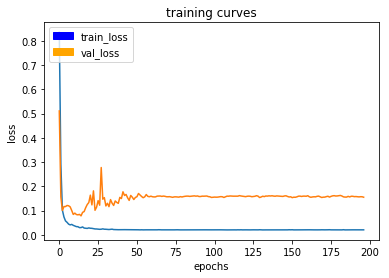


Epoch 00197: ReduceLROnPlateau reducing learning rate to 1.0430813157658037e-10.

Epoch 00197: val_loss did not improve from 0.07797
Epoch 198/250
40/40 [==============================] - 29s 733ms/step - loss: 0.0215 - val_loss: 0.1550


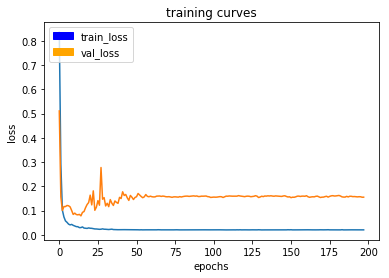


Epoch 00198: val_loss did not improve from 0.07797
Epoch 199/250
40/40 [==============================] - 29s 735ms/step - loss: 0.0207 - val_loss: 0.1573


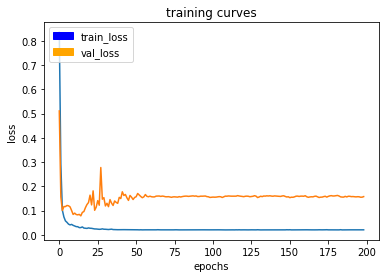


Epoch 00199: val_loss did not improve from 0.07797
Epoch 200/250
40/40 [==============================] - 29s 717ms/step - loss: 0.0213 - val_loss: 0.1568


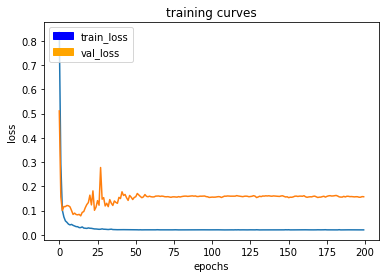


Epoch 00200: val_loss did not improve from 0.07797
Epoch 201/250
40/40 [==============================] - 31s 764ms/step - loss: 0.0202 - val_loss: 0.1571


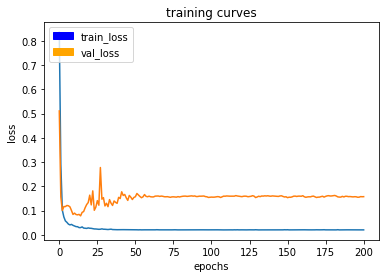


Epoch 00201: val_loss did not improve from 0.07797
Epoch 202/250
40/40 [==============================] - 29s 733ms/step - loss: 0.0219 - val_loss: 0.1573


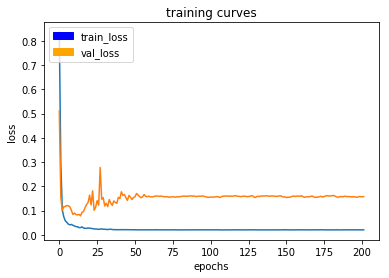


Epoch 00202: val_loss did not improve from 0.07797
Epoch 203/250
40/40 [==============================] - 30s 745ms/step - loss: 0.0211 - val_loss: 0.1570


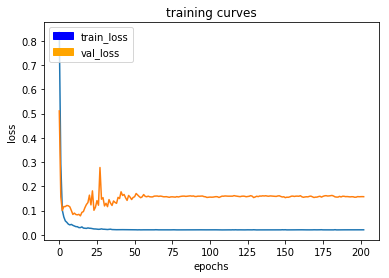


Epoch 00203: val_loss did not improve from 0.07797
Epoch 204/250
40/40 [==============================] - 29s 721ms/step - loss: 0.0222 - val_loss: 0.1578


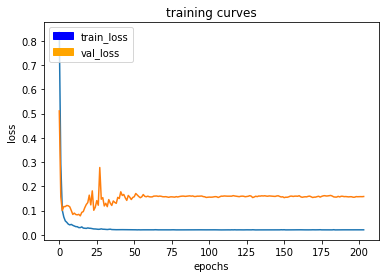


Epoch 00204: ReduceLROnPlateau reducing learning rate to 5.215406578829018e-11.

Epoch 00204: val_loss did not improve from 0.07797
Epoch 205/250
40/40 [==============================] - 29s 713ms/step - loss: 0.0274 - val_loss: 0.1544


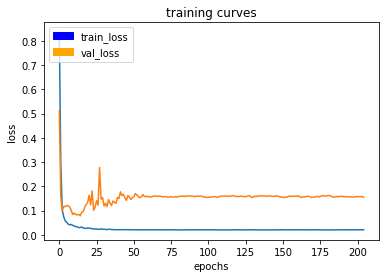


Epoch 00205: val_loss did not improve from 0.07797
Epoch 206/250
40/40 [==============================] - 29s 737ms/step - loss: 0.0204 - val_loss: 0.1552


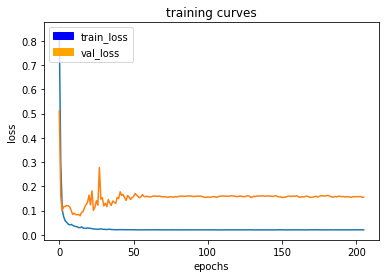


Epoch 00206: val_loss did not improve from 0.07797
Epoch 207/250
40/40 [==============================] - 30s 760ms/step - loss: 0.0206 - val_loss: 0.1569


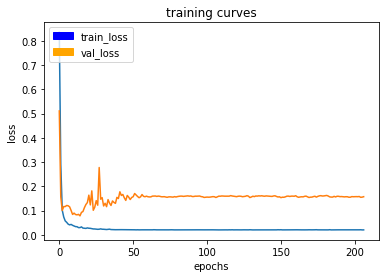


Epoch 00207: val_loss did not improve from 0.07797
Epoch 208/250
40/40 [==============================] - 30s 749ms/step - loss: 0.0206 - val_loss: 0.1587


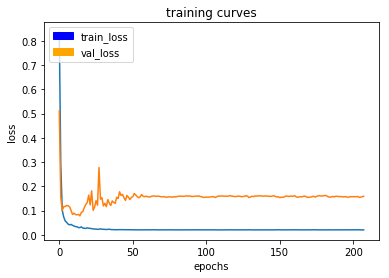


Epoch 00208: val_loss did not improve from 0.07797
Epoch 209/250
40/40 [==============================] - 29s 731ms/step - loss: 0.0198 - val_loss: 0.1601


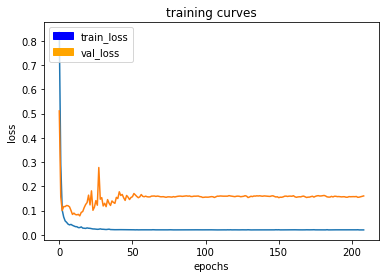


Epoch 00209: val_loss did not improve from 0.07797
Epoch 210/250
40/40 [==============================] - 29s 726ms/step - loss: 0.0206 - val_loss: 0.1599


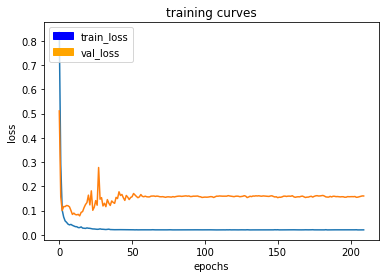


Epoch 00210: val_loss did not improve from 0.07797
Epoch 211/250
40/40 [==============================] - 30s 748ms/step - loss: 0.0198 - val_loss: 0.1594


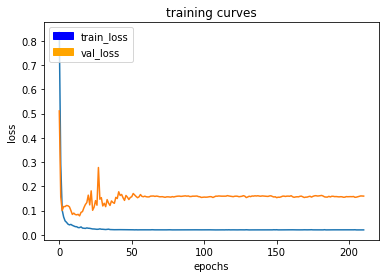


Epoch 00211: ReduceLROnPlateau reducing learning rate to 2.607703289414509e-11.

Epoch 00211: val_loss did not improve from 0.07797
Epoch 212/250
40/40 [==============================] - 30s 744ms/step - loss: 0.0214 - val_loss: 0.1586


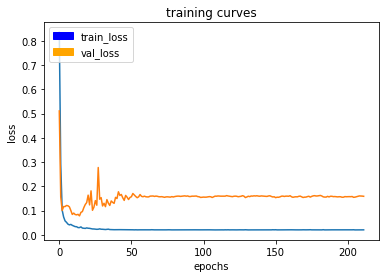


Epoch 00212: val_loss did not improve from 0.07797
Epoch 213/250
40/40 [==============================] - 29s 737ms/step - loss: 0.0218 - val_loss: 0.1576


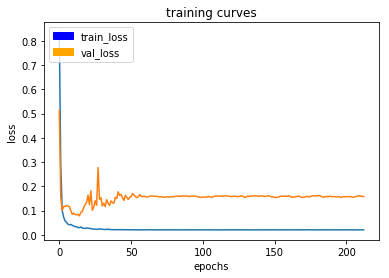


Epoch 00213: val_loss did not improve from 0.07797
Epoch 214/250
40/40 [==============================] - 29s 733ms/step - loss: 0.0218 - val_loss: 0.1565


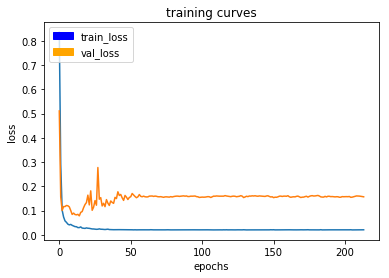


Epoch 00214: val_loss did not improve from 0.07797
Epoch 215/250
40/40 [==============================] - 30s 743ms/step - loss: 0.0206 - val_loss: 0.1560


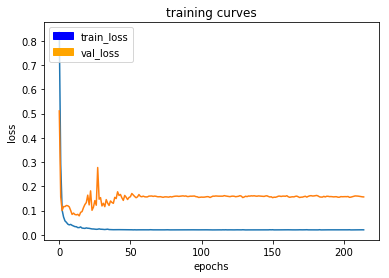


Epoch 00215: val_loss did not improve from 0.07797
Epoch 216/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0201 - val_loss: 0.1583


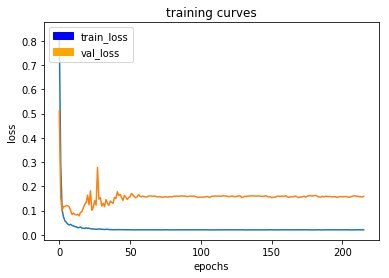


Epoch 00216: val_loss did not improve from 0.07797
Epoch 217/250
40/40 [==============================] - 29s 727ms/step - loss: 0.0215 - val_loss: 0.1572


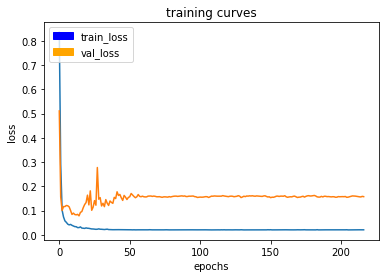


Epoch 00217: val_loss did not improve from 0.07797
Epoch 218/250
40/40 [==============================] - 29s 733ms/step - loss: 0.0196 - val_loss: 0.1580


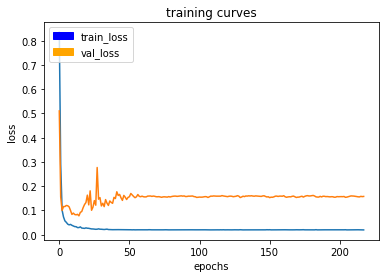


Epoch 00218: ReduceLROnPlateau reducing learning rate to 1.3038516447072546e-11.

Epoch 00218: val_loss did not improve from 0.07797
Epoch 219/250
40/40 [==============================] - 29s 729ms/step - loss: 0.0231 - val_loss: 0.1565


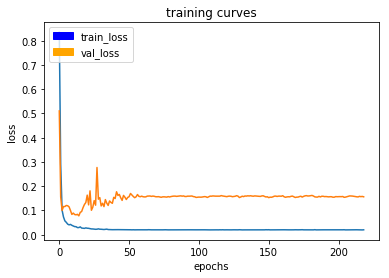


Epoch 00219: val_loss did not improve from 0.07797
Epoch 220/250
40/40 [==============================] - 30s 754ms/step - loss: 0.0242 - val_loss: 0.1539


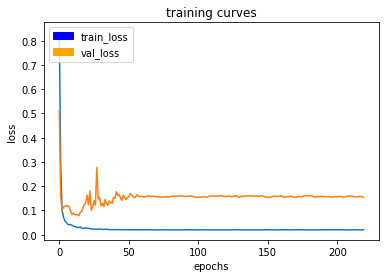


Epoch 00220: val_loss did not improve from 0.07797
Epoch 221/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0236 - val_loss: 0.1527


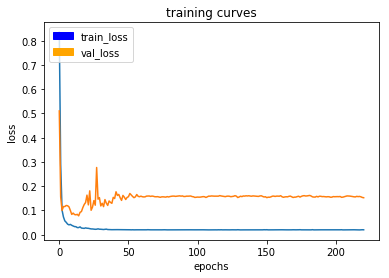


Epoch 00221: val_loss did not improve from 0.07797
Epoch 222/250
40/40 [==============================] - 31s 768ms/step - loss: 0.0214 - val_loss: 0.1534


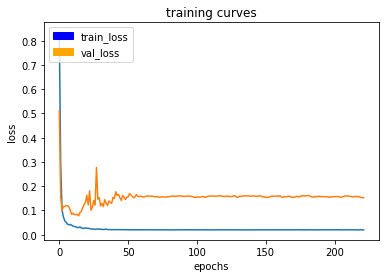


Epoch 00222: val_loss did not improve from 0.07797
Epoch 223/250
40/40 [==============================] - 30s 744ms/step - loss: 0.0219 - val_loss: 0.1539


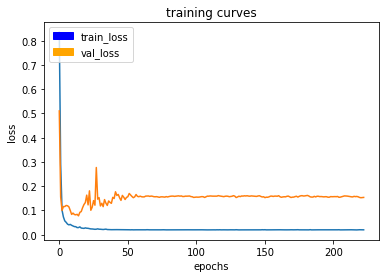


Epoch 00223: val_loss did not improve from 0.07797
Epoch 224/250
40/40 [==============================] - 30s 754ms/step - loss: 0.0199 - val_loss: 0.1569


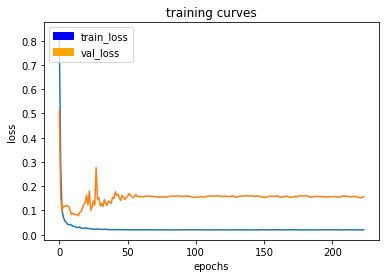


Epoch 00224: val_loss did not improve from 0.07797
Epoch 225/250
40/40 [==============================] - 29s 734ms/step - loss: 0.0224 - val_loss: 0.1557


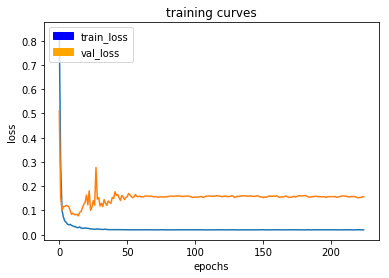


Epoch 00225: ReduceLROnPlateau reducing learning rate to 6.519258223536273e-12.

Epoch 00225: val_loss did not improve from 0.07797
Epoch 226/250
40/40 [==============================] - 29s 718ms/step - loss: 0.0226 - val_loss: 0.1574


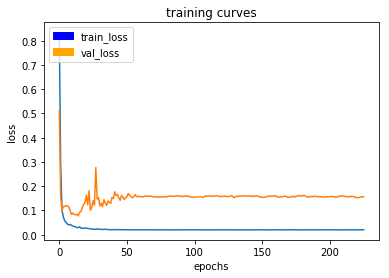


Epoch 00226: val_loss did not improve from 0.07797
Epoch 227/250
40/40 [==============================] - 30s 739ms/step - loss: 0.0224 - val_loss: 0.1559


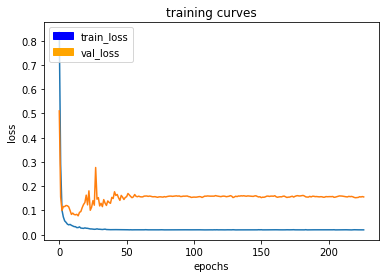


Epoch 00227: val_loss did not improve from 0.07797
Epoch 228/250
40/40 [==============================] - 30s 755ms/step - loss: 0.0214 - val_loss: 0.1576


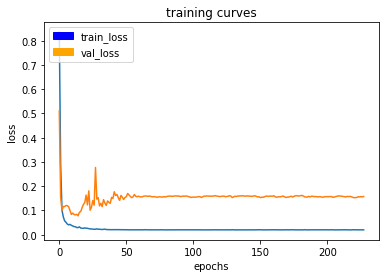


Epoch 00228: val_loss did not improve from 0.07797
Epoch 229/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0202 - val_loss: 0.1594


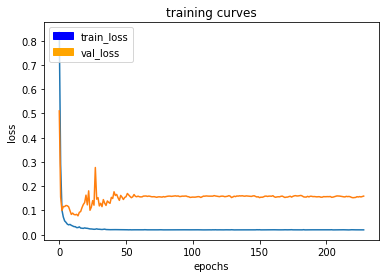


Epoch 00229: val_loss did not improve from 0.07797
Epoch 230/250
40/40 [==============================] - 29s 723ms/step - loss: 0.0239 - val_loss: 0.1585


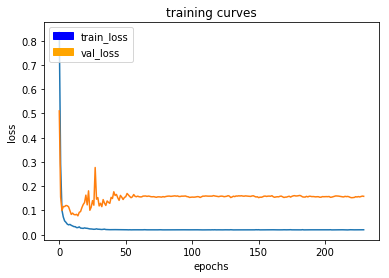


Epoch 00230: val_loss did not improve from 0.07797
Epoch 231/250
40/40 [==============================] - 30s 738ms/step - loss: 0.0217 - val_loss: 0.1583


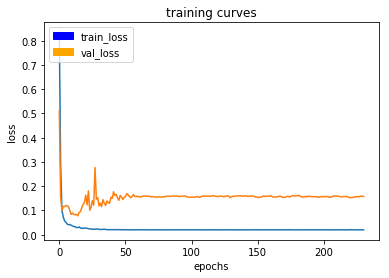


Epoch 00231: val_loss did not improve from 0.07797
Epoch 232/250
40/40 [==============================] - 31s 771ms/step - loss: 0.0203 - val_loss: 0.1593


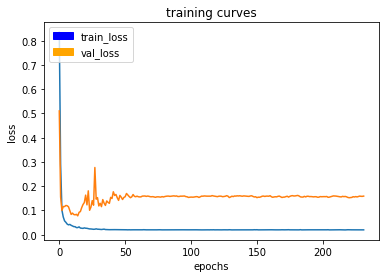


Epoch 00232: ReduceLROnPlateau reducing learning rate to 3.2596291117681364e-12.

Epoch 00232: val_loss did not improve from 0.07797
Epoch 233/250
40/40 [==============================] - 29s 716ms/step - loss: 0.0219 - val_loss: 0.1579


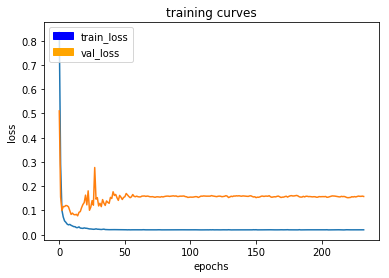


Epoch 00233: val_loss did not improve from 0.07797
Epoch 234/250
40/40 [==============================] - 29s 722ms/step - loss: 0.0205 - val_loss: 0.1591


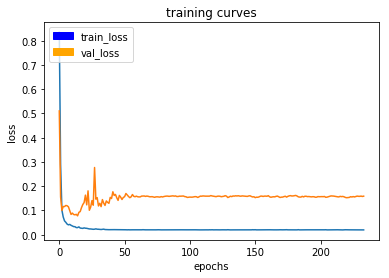


Epoch 00234: val_loss did not improve from 0.07797
Epoch 235/250
40/40 [==============================] - 29s 730ms/step - loss: 0.0201 - val_loss: 0.1595


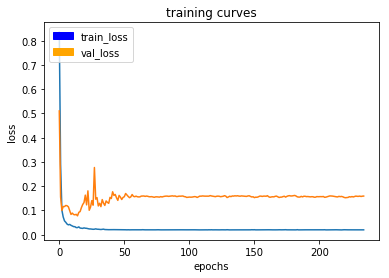


Epoch 00235: val_loss did not improve from 0.07797
Epoch 236/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0213 - val_loss: 0.1600


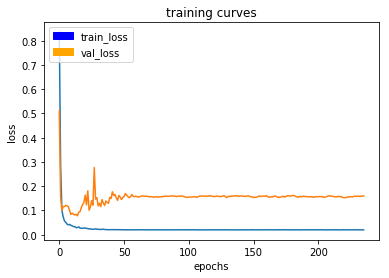


Epoch 00236: val_loss did not improve from 0.07797
Epoch 237/250
40/40 [==============================] - 30s 738ms/step - loss: 0.0230 - val_loss: 0.1566


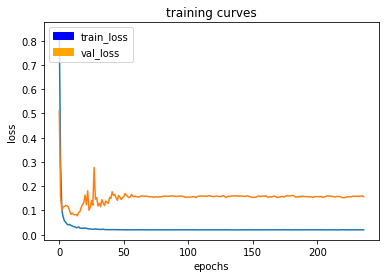


Epoch 00237: val_loss did not improve from 0.07797
Epoch 238/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0228 - val_loss: 0.1542


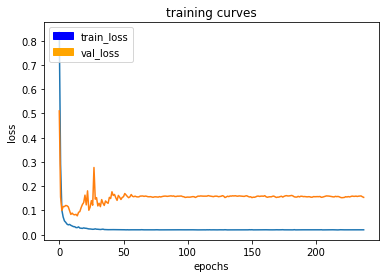


Epoch 00238: val_loss did not improve from 0.07797
Epoch 239/250
40/40 [==============================] - 29s 731ms/step - loss: 0.0197 - val_loss: 0.1573


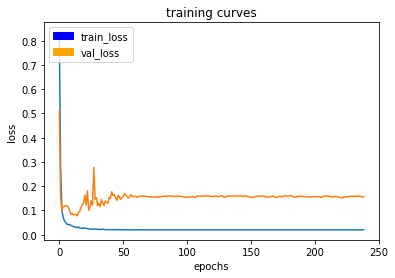


Epoch 00239: ReduceLROnPlateau reducing learning rate to 1.6298145558840682e-12.

Epoch 00239: val_loss did not improve from 0.07797
Epoch 240/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0218 - val_loss: 0.1568


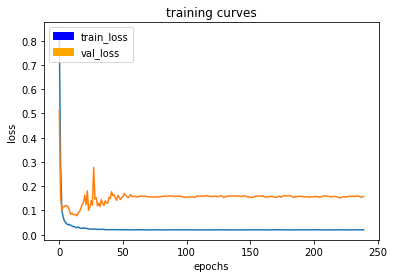


Epoch 00240: val_loss did not improve from 0.07797
Epoch 241/250
40/40 [==============================] - 29s 717ms/step - loss: 0.0207 - val_loss: 0.1565


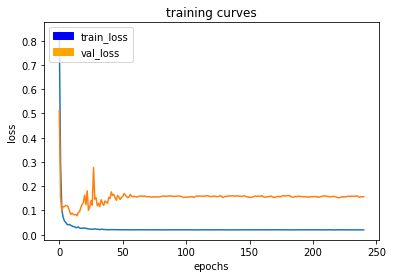


Epoch 00241: val_loss did not improve from 0.07797
Epoch 242/250
40/40 [==============================] - 29s 732ms/step - loss: 0.0199 - val_loss: 0.1573


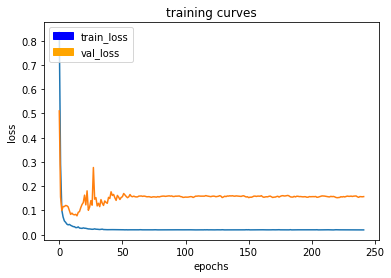


Epoch 00242: val_loss did not improve from 0.07797
Epoch 243/250
40/40 [==============================] - 29s 721ms/step - loss: 0.0209 - val_loss: 0.1575


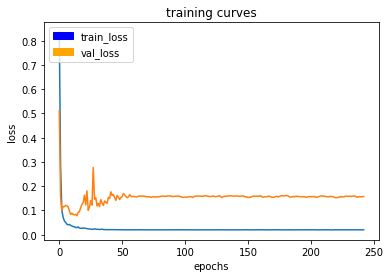


Epoch 00243: val_loss did not improve from 0.07797
Epoch 244/250
40/40 [==============================] - 30s 742ms/step - loss: 0.0221 - val_loss: 0.1550


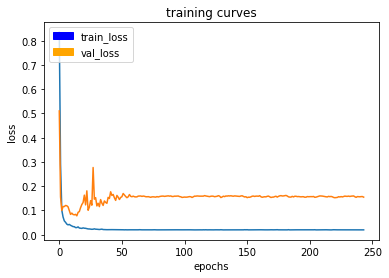


Epoch 00244: val_loss did not improve from 0.07797
Epoch 245/250
40/40 [==============================] - 29s 726ms/step - loss: 0.0216 - val_loss: 0.1555


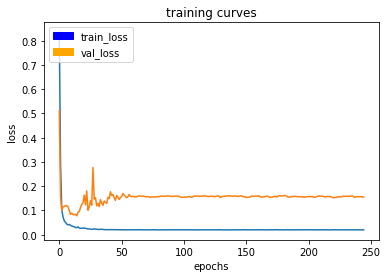


Epoch 00245: val_loss did not improve from 0.07797
Epoch 246/250
40/40 [==============================] - 29s 733ms/step - loss: 0.0204 - val_loss: 0.1563


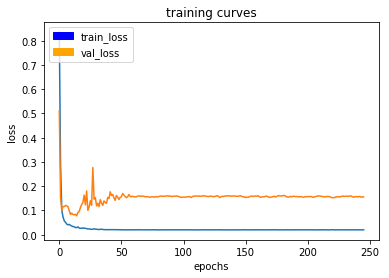


Epoch 00246: ReduceLROnPlateau reducing learning rate to 8.149072779420341e-13.

Epoch 00246: val_loss did not improve from 0.07797
Epoch 247/250
40/40 [==============================] - 29s 724ms/step - loss: 0.0202 - val_loss: 0.1590


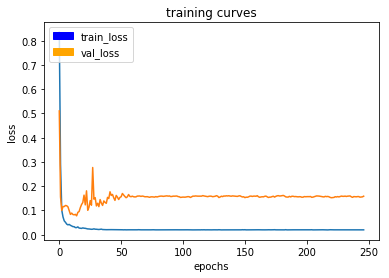


Epoch 00247: val_loss did not improve from 0.07797
Epoch 248/250
40/40 [==============================] - 30s 750ms/step - loss: 0.0224 - val_loss: 0.1568


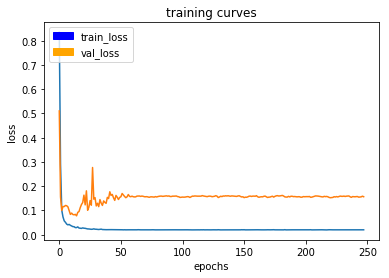


Epoch 00248: val_loss did not improve from 0.07797
Epoch 249/250
40/40 [==============================] - 30s 740ms/step - loss: 0.0201 - val_loss: 0.1586


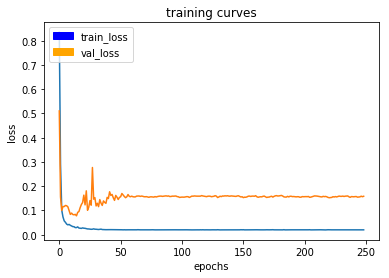


Epoch 00249: val_loss did not improve from 0.07797
Epoch 250/250
40/40 [==============================] - 29s 720ms/step - loss: 0.0197 - val_loss: 0.1598


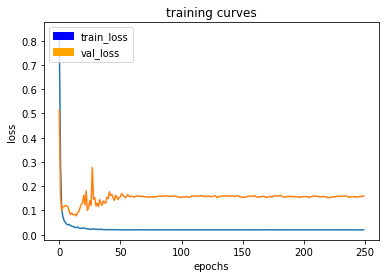


Epoch 00250: val_loss did not improve from 0.07797
Runtime is  7535.58252620697


In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, decay=decay_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

callbacks = []
callbacks.append(plotting_tools.LoggerPlotter())
#callbacks.append(EarlyStopping(monitor='val_loss', patience=10))
callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1))
#callbacks.append(TensorBoard(log_dir=os.path.join('..', 'logs')))
callbacks.append(ModelCheckpoint('../model/{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True))

time_start = time.time()
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)
print('Runtime is ', time.time() - time_start)


In [ ]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
#model.save('../model/final0.407.hdf5')
model = models.load_model('../model/final0.407.hdf5')

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
model = model_tools.load_network(weight_file_name)


The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [13]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

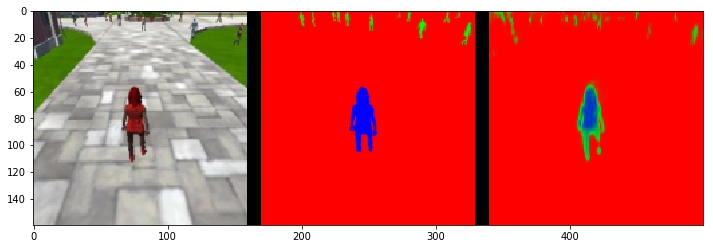

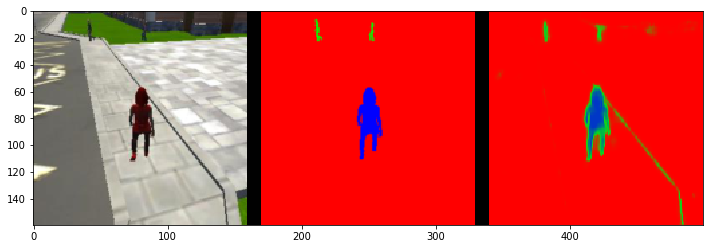

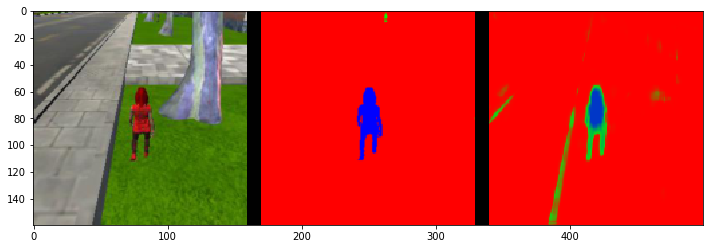

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

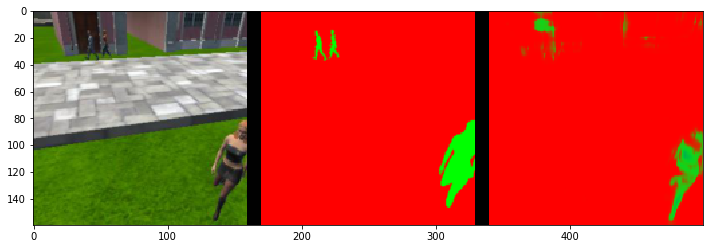

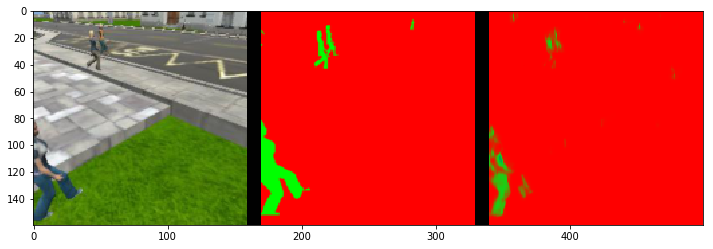

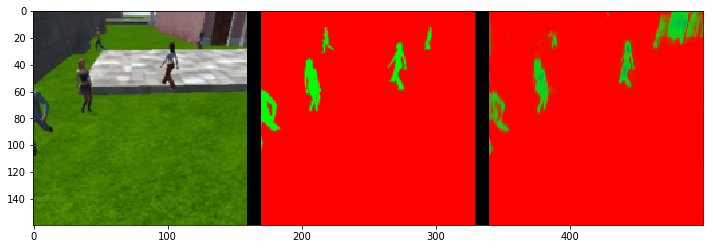

In [15]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

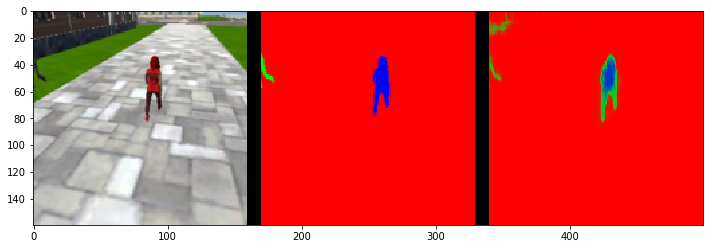

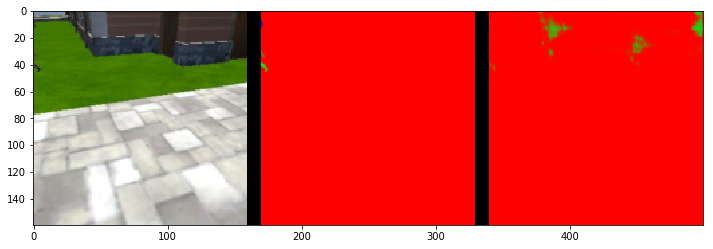

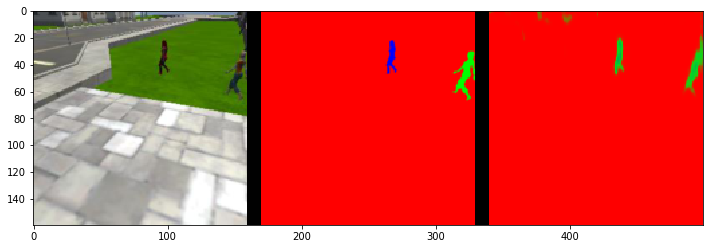

In [16]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9865243248236231
average intersection over union for other people is 0.09242719505025004
average intersection over union for the hero is 0.43610561103108997
number true positives: 539, number false positives: 0, number false negatives: 0


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9733019842727376
average intersection over union for other people is 0.5209289337398667
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 37, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9882607984057191
average intersection over union for other people is 0.22891689437206797
average intersection over union for the hero is 0.024964828779192854
number true positives: 38, number false positives: 0, number false negatives: 263


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6579247434435576


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.23053521990514142


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.1516748254107943
